In [2]:
import os
import random
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [4]:
NAN = '__NAN__'
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31
FOLDS = 3
ESTIMATORS = 1000

In [5]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [6]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019\sample_submission.csv
../input/data-science-bowl-2019\test.csv
../input/data-science-bowl-2019\test.csv.zip
../input/data-science-bowl-2019\train.csv
../input/data-science-bowl-2019\train.csv.zip
../input/data-science-bowl-2019\train_labels.csv
../input/data-science-bowl-2019\train_labels.csv.zip


In [7]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
Wall time: 51.4 s


# Add labels to train data

In [8]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [9]:
%%time
def _add_labels(train_raw, train_labels, on):
    train_raw = pd.merge(train_raw, train_labels, on=on, how='left')
    train_raw[TARGET] = np.int16(train_raw[TARGET])
    return train_raw


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

Wall time: 4.4 s


# Extract event data JSON

In [24]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=1000000):
    res = pd.DataFrame()
    _len = len(df)
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        ed = ed[keep_cols]
        chunk = _concat_columns(chunk, ed)
        res = pd.concat([res, chunk], ignore_index=True, sort=False)
    assert len(df) == len(res)
    return res


keep_cols = ['ed.identifier', 'ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses',
            'ed.weight', 'ed.total_duration', 'ed.source']
train_raw = _extract_event_data(train_raw, keep_cols)
test_raw = _extract_event_data(test_raw, keep_cols)













  0%|                                                            | 0/8 [00:00<?, ?it/s]











 12%|██████▍                                            | 1/8 [01:57<13:44, 117.81s/it]











 25%|████████████▊                                      | 2/8 [03:12<10:30, 105.00s/it]











 38%|███████████████████▌                                | 3/8 [04:31<08:05, 97.10s/it]











 50%|██████████████████████████                          | 4/8 [05:55<06:12, 93.06s/it]











 62%|████████████████████████████████▌                   | 5/8 [07:16<04:28, 89.41s/it]











 75%|███████████████████████████████████████             | 6/8 [08:38<02:54, 87.32s/it]











 88%|█████████████████████████████████████████████▌      | 7/8 [10:10<01:28, 88.70s/it]











100%|████████████████████████████████████████████████████| 8/8 [11:08<00:00, 83.61s/it]












  0%|                                                            | 0/2 [00:00<?, ?it/s]










In [25]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 20 columns):
event_id             1156414 non-null object
game_session         1156414 non-null object
timestamp            1156414 non-null object
event_data           1156414 non-null object
installation_id      1156414 non-null object
event_count          1156414 non-null int64
event_code           1156414 non-null int64
game_time            1156414 non-null int64
title                1156414 non-null object
type                 1156414 non-null object
world                1156414 non-null object
ed.identifier        337810 non-null object
ed.duration          336619 non-null float64
ed.level             84208 non-null float64
ed.round             598718 non-null float64
ed.correct           69806 non-null object
ed.misses            23658 non-null float64
ed.weight            50353 non-null float64
ed.total_duration    170228 non-null float64
ed.source            144623 non-null obje

In [26]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734558 entries, 0 to 7734557
Data columns (total 21 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           int64
game_time            int64
title                object
type                 object
world                object
accuracy_group       int16
ed.identifier        object
ed.duration          float64
ed.level             float64
ed.round             float64
ed.correct           object
ed.misses            float64
ed.weight            float64
ed.total_duration    float64
ed.source            object
dtypes: float64(6), int16(1), int64(3), object(11)
memory usage: 1.2+ GB


In [27]:
# All event ids in test set also exist in train set
test_set = set(test_raw['event_id'])
train_set = set(train_raw['event_id'])
vs = test_set - train_set
_log(f'{len(vs)} event_ids exist in test set but not train set.')

0 event_ids exist in test set but not train set.


In [28]:
EVENT_IDS = sorted(test_raw['event_id'].unique())
_log(f'{len(vs)} EVENT_IDS={vs}')

0 EVENT_IDS=set()


In [29]:
vs = sorted(train_raw['type'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['Activity', 'Assessment', 'Clip', 'Game']


In [30]:
vs = sorted(train_raw['world'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']


In [31]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [32]:
vs = sorted(train_raw['title'].unique())
_log(f'{len(vs)} train_raw titles={vs}')

44 train_raw titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [33]:
vs = sorted(test_raw['title'].unique())
_log(f'{len(vs)} test titles={vs}')

44 test titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [34]:
def _transform_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


train_raw = _transform_timestamp(train_raw)
test_raw = _transform_timestamp(test_raw)

In [35]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].fillna(NAN).astype(str)
    return df


cols = ['event_code', 'timestamp']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

Wall time: 1min 16s


In [36]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


train_raw = _sort_it(train_raw)
test_raw = _sort_it(test_raw)

Wall time: 26.2 s


# Multiple accuracy groups per installation id
In the train set, there are multiple accuracy groups per installation id. The task is to predict the accuracy group of the **last** assessment for a given installation id.

In [37]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id')[TARGET].nunique()
vs

installation_id
0006a69f    3
0006c192    3
00129856    2
001d0ed0    3
00225f67    1
           ..
ff9305d7    2
ff9715db    4
ffc90c32    3
ffd2871d    2
ffeb0b1b    2
Name: accuracy_group, Length: 3614, dtype: int64

In [38]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 21 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           object
game_time            int64
title                object
type                 object
world                object
accuracy_group       int16
ed.identifier        object
ed.duration          float64
ed.level             float64
ed.round             float64
ed.correct           object
ed.misses            float64
ed.weight            float64
ed.total_duration    float64
ed.source            object
dtypes: float64(6), int16(1), int64(2), object(12)
memory usage: 1.2+ GB


In [39]:
def _log_smoothing(df, cols):
    for col in cols:
        df[col] = np.log(df[col] + 1)
    return df


#cols = ['event_count', 'game_time']
#train = _log_smoothing(train, cols)
#test = _log_smoothing(test, cols)

In [40]:
train_raw.head(40)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group,ed.identifier,ed.duration,ed.level,ed.round,ed.correct,ed.misses,ed.weight,ed.total_duration,ed.source
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape",NaN,NaN,NaN,NaN,NaN,NaN,6758.0,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape",6925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
test_raw.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,ed.identifier,ed.duration,ed.level,ed.round,ed.correct,ed.misses,ed.weight,ed.total_duration,ed.source
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


# Train-test split not by time
Both train and test sets span the same time period.

In [42]:
_log(f'train[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
_log(f'test[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

train[timestamp] is from 2019-07-23 14:38:25.256000+00:00 to 2019-10-14 21:57:26.930000+00:00
test[timestamp] is from 2019-07-24 00:04:25.361000+00:00 to 2019-10-14 21:00:34.858000+00:00


# Feature Engineering

In [43]:
def _cutoff(df, TARGET):
    return df[df[TARGET].notna()]['timestamp'].max()


def _trim_events_after_last_assessment(df, cutoff):
    res = df[df['timestamp'] <= cutoff]
    #_log(f'cutoff: before={df.shape}, after={res.shape}')
    return res
    
    
def _target_variable(df, cutoff, TARGET):
    vs = df[df['timestamp'] == cutoff][TARGET].values
    assert len(set(vs)) == 1
    return int(float(vs[0]))
    
    
def _game_session_stats(df, col):
    vs = df.groupby(['game_session'])[col].transform('max')
    return (vs.median(), vs.max())


def _event_code_counts(df, code):
    total = np.int32([sum(df['event_code'] == code)])
    activity = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Activity'))])
    assessment = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Assessment'))])
    clip = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Clip'))])
    game = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Game'))])
    return (total, activity, assessment, clip, game)


def _event_data_features(df, suffix):
    res = {}
    res[f'ed_duration{suffix}'] = np.int32(df['ed.duration'].fillna(0).max())
    res[f'ed_total_duration{suffix}'] = np.int32(df['ed.total_duration'].fillna(0).max())
    res[f'ed_level{suffix}'] = np.int32(df['ed.level'].fillna(0).max())
    res[f'ed_round{suffix}'] = np.int32(df['ed.round'].fillna(0).max())
    res[f'ed_correct{suffix}'] = np.int32(df['ed.correct'].fillna(0).max())
    res[f'ed_misses{suffix}'] = np.int32(df['ed.misses'].fillna(0).max())
    res[f'ed_weight{suffix}'] = np.int32(df['ed.weight'].fillna(0).max())
    return res


def _features_map(df, EVENT_CODES, EVENT_IDS, suffix=''):
    res = {}
    res[f'type_activity{suffix}'] = np.int32([sum(df['type'] == 'Activity')])
    res[f'type_assessment{suffix}'] = np.int32([sum(df['type'] == 'Assessment')])
    res[f'type_clip{suffix}'] = np.int32([sum(df['type'] == 'Clip')])
    res[f'type_game{suffix}'] = np.int32([sum(df['type'] == 'Game')])
    assert len(df) == res[f'type_activity{suffix}'][0] + res[f'type_assessment{suffix}'][0] + res[f'type_clip{suffix}'][0] + res[f'type_game{suffix}'][0]
    res[f'world_crystalcaves{suffix}'] = np.int32([sum(df['world'] == 'CRYSTALCAVES')])
    res[f'world_magmapeak{suffix}'] = np.int32([sum(df['world'] == 'MAGMAPEAK')])
    res[f'world_treetopcity{suffix}'] = np.int32([sum(df['world'] == 'TREETOPCITY')])
    res[f'world_none{suffix}'] = np.int32([sum(df['world'] == 'NONE')])
    res[f'title_12_monkeys{suffix}'] = np.int32([sum(df['title'] == '12 Monkeys')])
    res[f'title_air_show{suffix}'] = np.int32([sum(df['title'] == 'Air Show')])
    res[f'title_all_star_sorting{suffix}'] = np.int32([sum(df['title'] == 'All Star Sorting')])
    res[f'title_balancing_act{suffix}'] = np.int32([sum(df['title'] == 'Balancing Act')])
    res[f'title_bird_measurer{suffix}'] = np.int32([sum(df['title'] == 'Bird Measurer (Assessment)')])
    res[f'title_bottle_filler{suffix}'] = np.int32([sum(df['title'] == 'Bottle Filler (Activity)')])
    res[f'title_bubble_bath{suffix}'] = np.int32([sum(df['title'] == 'Bubble Bath')])
    res[f'title_bug_measurer{suffix}'] = np.int32([sum(df['title'] == 'Bug Measurer (Activity)')])
    res[f'title_cart_balancer{suffix}'] = np.int32([sum(df['title'] == 'Cart Balancer (Assessment)')])
    res[f'title_cauldron_filler{suffix}'] = np.int32([sum(df['title'] == 'Cauldron Filler (Assessment)')])
    res[f'title_chest_sorter{suffix}'] = np.int32([sum(df['title'] == 'Chest Sorter (Assessment)')])
    res[f'title_chicken_balancer{suffix}'] = np.int32([sum(df['title'] == 'Chicken Balancer (Activity)')])
    res[f'title_chow_time{suffix}'] = np.int32([sum(df['title'] == 'Chow Time')])
    res[f'title_costume_box{suffix}'] = np.int32([sum(df['title'] == 'Costume Box')])
    res[f'title_crystal_caves_1{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 1')])
    res[f'title_crystal_caves_2{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 2')])
    res[f'title_crystal_caves_3{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 3')])
    res[f'title_crystals_rule{suffix}'] = np.int32([sum(df['title'] == 'Crystals Rule')])
    res[f'title_dino_dive{suffix}'] = np.int32([sum(df['title'] == 'Dino Dive')])
    res[f'title_dino_drink{suffix}'] = np.int32([sum(df['title'] == 'Dino Drink')])
    res[f'title_egg_dropper{suffix}'] = np.int32([sum(df['title'] == 'Egg Dropper (Activity)')])
    res[f'title_fireworks{suffix}'] = np.int32([sum(df['title'] == 'Fireworks (Activity)')])
    res[f'title_flower_waterer{suffix}'] = np.int32([sum(df['title'] == 'Flower Waterer (Activity)')])
    res[f'title_happy_camel{suffix}'] = np.int32([sum(df['title'] == 'Happy Camel')])
    res[f'title_heavy{suffix}'] = np.int32([sum(df['title'] == 'Heavy, Heavier, Heaviest')])
    res[f'title_honey_cake{suffix}'] = np.int32([sum(df['title'] == 'Honey Cake')])
    res[f'title_leaf_leader{suffix}'] = np.int32([sum(df['title'] == 'Leaf Leader')])
    res[f'title_lifting{suffix}'] = np.int32([sum(df['title'] == 'Lifting Heavy Things')])
    res[f'title_magma_peak_1{suffix}'] = np.int32([sum(df['title'] == 'Magma Peak - Level 1')])
    res[f'title_magma_peak_2{suffix}'] = np.int32([sum(df['title'] == 'Magma Peak - Level 2')])
    res[f'title_mushroom_sorter{suffix}'] = np.int32([sum(df['title'] == 'Mushroom Sorter (Assessment)')])
    res[f'title_ordering_spheres{suffix}'] = np.int32([sum(df['title'] == 'Ordering Spheres')])
    res[f'title_pan_balance{suffix}'] = np.int32([sum(df['title'] == 'Pan Balance')])
    res[f'title_pirate_tale{suffix}'] = np.int32([sum(df['title'] == "Pirate's Tale")])
    res[f'title_rulers{suffix}'] = np.int32([sum(df['title'] == 'Rulers')])
    res[f'title_sandcastle{suffix}'] = np.int32([sum(df['title'] == 'Sandcastle Builder (Activity)')])
    res[f'title_scrub{suffix}'] = np.int32([sum(df['title'] == 'Scrub-A-Dub')])
    res[f'title_slop{suffix}'] = np.int32([sum(df['title'] == 'Slop Problem')])
    res[f'title_treasure_map{suffix}'] = np.int32([sum(df['title'] == 'Treasure Map')])
    res[f'title_treetop_city_1{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 1')])
    res[f'title_treetop_city_2{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 2')])
    res[f'title_treetop_city_3{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 3')])
    res[f'title_watering_hole{suffix}'] = np.int32([sum(df['title'] == 'Watering Hole (Activity)')])
    res[f'title_welcome{suffix}'] = np.int32([sum(df['title'] == 'Welcome to Lost Lagoon!')])
    
    for code in EVENT_CODES:
        (total, activity, assessment, clip, game) = _event_code_counts(df, code)
        res[f'event_{code}{suffix}'] = total
        res[f'event_{code}_activity{suffix}'] = activity
        res[f'event_{code}_assessment{suffix}'] = assessment
        res[f'event_{code}_clip{suffix}'] = clip
        res[f'event_{code}_game{suffix}'] = game
    
    for eid in EVENT_IDS:
        res[f'eid_{eid}{suffix}'] = np.int32([sum(df['event_id'] == eid)])
    
    res[f'game_time{suffix}'] = np.int32(df['game_time'].max())
    res[f'event_count{suffix}'] = np.int32(df['event_count'].max())
    res.update(_event_data_features(df, suffix))
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS):
    res = {}
    iid = df[df['installation_id'] == installation_id].copy()
    if TARGET in df.columns:
        cutoff = _cutoff(iid, TARGET)
        iid = _trim_events_after_last_assessment(iid, cutoff)
        res[TARGET] = _target_variable(iid, cutoff, TARGET)
    res['installation_id'] = [installation_id]
    cols = ['game_time', 'event_count']
    for col in cols:
        (_median, _max) = np.int32(_game_session_stats(iid, col))
        res[f'{col}_p50'] = _median
        res[f'{col}_max'] = _max
    res.update(_features_map(iid, EVENT_CODES, EVENT_IDS))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS):
    res = pd.DataFrame()
    iids = raw['installation_id'].unique()
    for iid in tqdm(iids):
        res = pd.concat([res, _features(raw, iid, EVENT_CODES, EVENT_IDS)], ignore_index=True)
    return res


train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS)
train.info(max_cols=999)













  0%|                                                         | 0/3614 [00:00<?, ?it/s]











  0%|                                               | 1/3614 [00:01<1:09:11,  1.15s/it]











  0%|                                               | 2/3614 [00:02<1:05:30,  1.09s/it]











  0%|                                               | 3/3614 [00:02<1:00:37,  1.01s/it]











  0%|                                                 | 4/3614 [00:03<57:16,  1.05it/s]











  0%|                                                 | 5/3614 [00:04<54:51,  1.10it/s]











  0%|                                               | 6/3614 [00:05<1:01:56,  1.03s/it]











  0%|                                               | 7/3614 [00:06<1:03:16,  1.05s/it]











  0%|                                               | 8/3614 [00:07<1:00:35,  1.01s/it]











  0%|                                                 | 9/3614 [00:08<56:08,  1.07it/s]











  2%|▊                                               | 60/3614 [00:55<59:13,  1.00it/s]











  2%|▊                                               | 61/3614 [00:56<54:58,  1.08it/s]











  2%|▊                                               | 62/3614 [00:57<52:29,  1.13it/s]











  2%|▊                                               | 63/3614 [00:57<49:38,  1.19it/s]











  2%|▊                                               | 64/3614 [00:58<49:11,  1.20it/s]











  2%|▊                                               | 65/3614 [00:59<47:45,  1.24it/s]











  2%|▉                                               | 66/3614 [01:00<48:05,  1.23it/s]











  2%|▉                                               | 67/3614 [01:01<47:39,  1.24it/s]











  2%|▉                                               | 68/3614 [01:02<58:57,  1.00it/s]











  2%|▉                                             | 69/3614 [01:03<1:02:45,  1.06s/it]











  2%|▉    

  3%|█▌                                             | 120/3614 [01:55<49:10,  1.18it/s]











  3%|█▌                                             | 121/3614 [01:56<51:05,  1.14it/s]











  3%|█▌                                             | 122/3614 [01:57<50:08,  1.16it/s]











  3%|█▌                                             | 123/3614 [01:58<49:10,  1.18it/s]











  3%|█▌                                             | 124/3614 [01:59<47:10,  1.23it/s]











  3%|█▋                                             | 125/3614 [01:59<48:39,  1.20it/s]











  3%|█▋                                             | 126/3614 [02:00<46:39,  1.25it/s]











  4%|█▌                                           | 127/3614 [02:02<1:01:13,  1.05s/it]











  4%|█▋                                             | 128/3614 [02:03<57:05,  1.02it/s]











  4%|█▋                                             | 129/3614 [02:03<53:24,  1.09it/s]











  4%|█▌   

  5%|██▎                                            | 180/3614 [02:50<47:15,  1.21it/s]











  5%|██▎                                            | 181/3614 [02:51<46:42,  1.22it/s]











  5%|██▎                                            | 182/3614 [02:51<45:37,  1.25it/s]











  5%|██▍                                            | 183/3614 [02:52<51:03,  1.12it/s]











  5%|██▍                                            | 184/3614 [02:54<58:17,  1.02s/it]











  5%|██▍                                            | 185/3614 [02:55<53:32,  1.07it/s]











  5%|██▍                                            | 186/3614 [02:55<52:43,  1.08it/s]











  5%|██▍                                            | 187/3614 [02:56<49:32,  1.15it/s]











  5%|██▎                                          | 188/3614 [02:59<1:19:16,  1.39s/it]











  5%|██▎                                          | 189/3614 [03:01<1:27:17,  1.53s/it]











  5%|██▎  

  7%|███                                            | 240/3614 [03:46<46:01,  1.22it/s]











  7%|███▏                                           | 241/3614 [03:47<44:59,  1.25it/s]











  7%|███▏                                           | 242/3614 [03:48<48:09,  1.17it/s]











  7%|███▏                                           | 243/3614 [03:49<47:34,  1.18it/s]











  7%|███▏                                           | 244/3614 [03:50<46:58,  1.20it/s]











  7%|███▏                                           | 245/3614 [03:50<46:11,  1.22it/s]











  7%|███▏                                           | 246/3614 [03:51<45:45,  1.23it/s]











  7%|███▏                                           | 247/3614 [03:52<44:06,  1.27it/s]











  7%|███▏                                           | 248/3614 [03:53<46:29,  1.21it/s]











  7%|███▏                                           | 249/3614 [03:54<49:27,  1.13it/s]











  7%|███▎ 

  8%|███▉                                           | 300/3614 [04:41<53:59,  1.02it/s]











  8%|███▋                                         | 301/3614 [04:42<1:01:09,  1.11s/it]











  8%|███▉                                           | 302/3614 [04:43<58:32,  1.06s/it]











  8%|███▊                                         | 303/3614 [04:44<1:01:10,  1.11s/it]











  8%|███▉                                           | 304/3614 [04:45<56:08,  1.02s/it]











  8%|███▉                                           | 305/3614 [04:46<54:09,  1.02it/s]











  8%|███▉                                           | 306/3614 [04:47<49:37,  1.11it/s]











  8%|███▉                                           | 307/3614 [04:48<49:16,  1.12it/s]











  9%|████                                           | 308/3614 [04:49<47:27,  1.16it/s]











  9%|████                                           | 309/3614 [04:49<47:16,  1.17it/s]











  9%|████ 

 10%|████▋                                          | 360/3614 [05:34<42:19,  1.28it/s]











 10%|████▋                                          | 361/3614 [05:35<44:02,  1.23it/s]











 10%|████▋                                          | 362/3614 [05:37<51:46,  1.05it/s]











 10%|████▋                                          | 363/3614 [05:37<48:26,  1.12it/s]











 10%|████▋                                          | 364/3614 [05:38<46:23,  1.17it/s]











 10%|████▋                                          | 365/3614 [05:39<44:27,  1.22it/s]











 10%|████▊                                          | 366/3614 [05:40<43:19,  1.25it/s]











 10%|████▊                                          | 367/3614 [05:40<43:04,  1.26it/s]











 10%|████▊                                          | 368/3614 [05:41<46:11,  1.17it/s]











 10%|████▊                                          | 369/3614 [05:43<54:41,  1.01s/it]











 10%|████▊

 12%|█████▍                                         | 420/3614 [06:32<53:08,  1.00it/s]











 12%|█████▏                                       | 421/3614 [06:34<1:06:16,  1.25s/it]











 12%|█████▍                                         | 422/3614 [06:35<59:36,  1.12s/it]











 12%|█████▎                                       | 423/3614 [06:36<1:11:46,  1.35s/it]











 12%|█████▎                                       | 424/3614 [06:37<1:02:54,  1.18s/it]











 12%|█████▎                                       | 425/3614 [06:39<1:13:24,  1.38s/it]











 12%|█████▎                                       | 426/3614 [06:40<1:08:24,  1.29s/it]











 12%|█████▎                                       | 427/3614 [06:41<1:01:19,  1.15s/it]











 12%|█████▌                                         | 428/3614 [06:42<59:00,  1.11s/it]











 12%|█████▌                                         | 429/3614 [06:43<55:50,  1.05s/it]











 12%|█████

 13%|██████▏                                        | 480/3614 [07:31<54:42,  1.05s/it]











 13%|██████▎                                        | 481/3614 [07:32<51:17,  1.02it/s]











 13%|██████▎                                        | 482/3614 [07:34<58:06,  1.11s/it]











 13%|██████▎                                        | 483/3614 [07:34<52:56,  1.01s/it]











 13%|██████▎                                        | 484/3614 [07:35<51:22,  1.02it/s]











 13%|██████▎                                        | 485/3614 [07:36<48:14,  1.08it/s]











 13%|██████▎                                        | 486/3614 [07:37<49:01,  1.06it/s]











 13%|██████▎                                        | 487/3614 [07:38<46:27,  1.12it/s]











 14%|██████▎                                        | 488/3614 [07:39<44:03,  1.18it/s]











 14%|██████▎                                        | 489/3614 [07:39<42:53,  1.21it/s]











 14%|█████

 15%|███████                                        | 540/3614 [08:26<48:06,  1.06it/s]











 15%|███████                                        | 541/3614 [08:27<45:33,  1.12it/s]











 15%|███████                                        | 542/3614 [08:28<46:25,  1.10it/s]











 15%|███████                                        | 543/3614 [08:29<46:06,  1.11it/s]











 15%|███████                                        | 544/3614 [08:29<44:45,  1.14it/s]











 15%|███████                                        | 545/3614 [08:31<50:34,  1.01it/s]











 15%|███████                                        | 546/3614 [08:31<46:46,  1.09it/s]











 15%|███████                                        | 547/3614 [08:33<53:24,  1.04s/it]











 15%|███████▏                                       | 548/3614 [08:34<54:25,  1.07s/it]











 15%|███████▏                                       | 549/3614 [08:35<51:27,  1.01s/it]











 15%|█████

 17%|███████▊                                       | 600/3614 [09:23<51:17,  1.02s/it]











 17%|███████▊                                       | 601/3614 [09:24<49:32,  1.01it/s]











 17%|███████▊                                       | 602/3614 [09:24<46:18,  1.08it/s]











 17%|███████▊                                       | 603/3614 [09:25<43:13,  1.16it/s]











 17%|███████▊                                       | 604/3614 [09:26<42:00,  1.19it/s]











 17%|███████▊                                       | 605/3614 [09:27<41:56,  1.20it/s]











 17%|███████▉                                       | 606/3614 [09:28<42:27,  1.18it/s]











 17%|███████▉                                       | 607/3614 [09:29<43:15,  1.16it/s]











 17%|███████▉                                       | 608/3614 [09:29<41:17,  1.21it/s]











 17%|███████▉                                       | 609/3614 [09:30<43:51,  1.14it/s]











 17%|█████

 18%|████████▌                                      | 660/3614 [10:20<48:30,  1.01it/s]











 18%|████████▏                                    | 661/3614 [10:22<1:00:28,  1.23s/it]











 18%|████████▌                                      | 662/3614 [10:23<56:05,  1.14s/it]











 18%|████████▌                                      | 663/3614 [10:24<54:59,  1.12s/it]











 18%|████████▋                                      | 664/3614 [10:25<52:06,  1.06s/it]











 18%|████████▋                                      | 665/3614 [10:26<47:55,  1.03it/s]











 18%|████████▋                                      | 666/3614 [10:26<45:07,  1.09it/s]











 18%|████████▋                                      | 667/3614 [10:27<43:21,  1.13it/s]











 18%|████████▋                                      | 668/3614 [10:28<44:31,  1.10it/s]











 19%|████████▋                                      | 669/3614 [10:29<43:06,  1.14it/s]











 19%|█████

 20%|█████████▎                                     | 720/3614 [11:19<46:57,  1.03it/s]











 20%|█████████▍                                     | 721/3614 [11:20<50:47,  1.05s/it]











 20%|█████████▍                                     | 722/3614 [11:21<48:35,  1.01s/it]











 20%|█████████▍                                     | 723/3614 [11:22<45:35,  1.06it/s]











 20%|█████████                                    | 724/3614 [11:24<1:05:16,  1.36s/it]











 20%|█████████▍                                     | 725/3614 [11:25<59:05,  1.23s/it]











 20%|█████████▍                                     | 726/3614 [11:26<56:36,  1.18s/it]











 20%|█████████▍                                     | 727/3614 [11:27<51:36,  1.07s/it]











 20%|█████████▍                                     | 728/3614 [11:28<48:28,  1.01s/it]











 20%|█████████▍                                     | 729/3614 [11:29<49:38,  1.03s/it]











 20%|█████

 22%|██████████▏                                    | 780/3614 [12:18<44:22,  1.06it/s]











 22%|██████████▏                                    | 781/3614 [12:19<44:42,  1.06it/s]











 22%|█████████▋                                   | 782/3614 [12:21<1:02:11,  1.32s/it]











 22%|██████████▏                                    | 783/3614 [12:22<56:32,  1.20s/it]











 22%|██████████▏                                    | 784/3614 [12:23<50:35,  1.07s/it]











 22%|██████████▏                                    | 785/3614 [12:24<51:38,  1.10s/it]











 22%|██████████▏                                    | 786/3614 [12:25<48:52,  1.04s/it]











 22%|██████████▏                                    | 787/3614 [12:26<47:18,  1.00s/it]











 22%|██████████▏                                    | 788/3614 [12:26<43:27,  1.08it/s]











 22%|██████████▎                                    | 789/3614 [12:27<42:10,  1.12it/s]











 22%|█████

 23%|██████████▉                                    | 840/3614 [13:14<41:12,  1.12it/s]











 23%|██████████▉                                    | 841/3614 [13:15<42:38,  1.08it/s]











 23%|██████████▉                                    | 842/3614 [13:16<42:43,  1.08it/s]











 23%|██████████▉                                    | 843/3614 [13:17<41:25,  1.12it/s]











 23%|██████████▉                                    | 844/3614 [13:18<47:17,  1.02s/it]











 23%|██████████▉                                    | 845/3614 [13:19<44:24,  1.04it/s]











 23%|███████████                                    | 846/3614 [13:20<47:13,  1.02s/it]











 23%|███████████                                    | 847/3614 [13:21<43:57,  1.05it/s]











 23%|███████████                                    | 848/3614 [13:22<41:30,  1.11it/s]











 23%|███████████                                    | 849/3614 [13:22<40:00,  1.15it/s]











 24%|█████

 25%|███████████▋                                   | 900/3614 [14:10<40:47,  1.11it/s]











 25%|███████████▋                                   | 901/3614 [14:11<41:42,  1.08it/s]











 25%|███████████▋                                   | 902/3614 [14:12<41:11,  1.10it/s]











 25%|███████████▋                                   | 903/3614 [14:12<39:07,  1.15it/s]











 25%|███████████▊                                   | 904/3614 [14:13<38:12,  1.18it/s]











 25%|███████████▊                                   | 905/3614 [14:14<37:19,  1.21it/s]











 25%|███████████▊                                   | 906/3614 [14:15<36:25,  1.24it/s]











 25%|███████████▊                                   | 907/3614 [14:16<42:27,  1.06it/s]











 25%|███████████▊                                   | 908/3614 [14:17<44:35,  1.01it/s]











 25%|███████████▊                                   | 909/3614 [14:18<42:59,  1.05it/s]











 25%|█████

 27%|████████████▍                                  | 960/3614 [15:09<41:49,  1.06it/s]











 27%|████████████▍                                  | 961/3614 [15:10<39:30,  1.12it/s]











 27%|████████████▌                                  | 962/3614 [15:11<39:43,  1.11it/s]











 27%|████████████▌                                  | 963/3614 [15:11<39:53,  1.11it/s]











 27%|████████████▌                                  | 964/3614 [15:12<38:08,  1.16it/s]











 27%|████████████▌                                  | 965/3614 [15:13<39:28,  1.12it/s]











 27%|████████████▌                                  | 966/3614 [15:14<38:49,  1.14it/s]











 27%|████████████▌                                  | 967/3614 [15:15<37:15,  1.18it/s]











 27%|████████████▌                                  | 968/3614 [15:16<37:23,  1.18it/s]











 27%|████████████▌                                  | 969/3614 [15:16<35:45,  1.23it/s]











 27%|█████

 28%|████████████▉                                 | 1020/3614 [16:03<41:21,  1.05it/s]











 28%|████████████▉                                 | 1021/3614 [16:04<45:22,  1.05s/it]











 28%|█████████████                                 | 1022/3614 [16:05<41:34,  1.04it/s]











 28%|█████████████                                 | 1023/3614 [16:06<39:07,  1.10it/s]











 28%|█████████████                                 | 1024/3614 [16:06<39:03,  1.11it/s]











 28%|█████████████                                 | 1025/3614 [16:07<40:47,  1.06it/s]











 28%|█████████████                                 | 1026/3614 [16:08<38:30,  1.12it/s]











 28%|█████████████                                 | 1027/3614 [16:09<36:47,  1.17it/s]











 28%|█████████████                                 | 1028/3614 [16:10<36:10,  1.19it/s]











 28%|█████████████                                 | 1029/3614 [16:11<34:53,  1.23it/s]











 29%|█████

 30%|█████████████▋                                | 1080/3614 [16:55<38:19,  1.10it/s]











 30%|█████████████▊                                | 1081/3614 [16:56<37:12,  1.13it/s]











 30%|█████████████▊                                | 1082/3614 [16:57<38:02,  1.11it/s]











 30%|█████████████▊                                | 1083/3614 [16:58<36:37,  1.15it/s]











 30%|█████████████▊                                | 1084/3614 [16:59<38:55,  1.08it/s]











 30%|█████████████▊                                | 1085/3614 [17:00<37:25,  1.13it/s]











 30%|█████████████▊                                | 1086/3614 [17:01<36:04,  1.17it/s]











 30%|█████████████▊                                | 1087/3614 [17:02<36:53,  1.14it/s]











 30%|█████████████▊                                | 1088/3614 [17:03<38:08,  1.10it/s]











 30%|█████████████▊                                | 1089/3614 [17:05<59:12,  1.41s/it]











 30%|█████

 32%|██████████████▌                               | 1140/3614 [17:59<38:57,  1.06it/s]











 32%|██████████████▌                               | 1141/3614 [18:00<37:12,  1.11it/s]











 32%|██████████████▌                               | 1142/3614 [18:01<36:34,  1.13it/s]











 32%|██████████████▌                               | 1143/3614 [18:02<35:08,  1.17it/s]











 32%|██████████████▌                               | 1144/3614 [18:03<33:36,  1.23it/s]











 32%|██████████████▌                               | 1145/3614 [18:03<35:03,  1.17it/s]











 32%|██████████████▌                               | 1146/3614 [18:04<34:19,  1.20it/s]











 32%|██████████████▌                               | 1147/3614 [18:05<33:44,  1.22it/s]











 32%|██████████████▌                               | 1148/3614 [18:06<34:04,  1.21it/s]











 32%|██████████████▌                               | 1149/3614 [18:07<34:49,  1.18it/s]











 32%|█████

 33%|███████████████▎                              | 1200/3614 [18:55<36:22,  1.11it/s]











 33%|███████████████▎                              | 1201/3614 [18:56<38:21,  1.05it/s]











 33%|███████████████▎                              | 1202/3614 [18:57<38:37,  1.04it/s]











 33%|███████████████▎                              | 1203/3614 [18:58<36:11,  1.11it/s]











 33%|███████████████▎                              | 1204/3614 [18:59<39:53,  1.01it/s]











 33%|███████████████▎                              | 1205/3614 [19:00<36:46,  1.09it/s]











 33%|███████████████▎                              | 1206/3614 [19:01<36:12,  1.11it/s]











 33%|███████████████▎                              | 1207/3614 [19:02<46:25,  1.16s/it]











 33%|███████████████▍                              | 1208/3614 [19:03<41:25,  1.03s/it]











 33%|███████████████▍                              | 1209/3614 [19:04<45:02,  1.12s/it]











 33%|█████

 35%|████████████████                              | 1260/3614 [19:52<33:34,  1.17it/s]











 35%|████████████████                              | 1261/3614 [19:53<33:02,  1.19it/s]











 35%|████████████████                              | 1262/3614 [19:53<31:42,  1.24it/s]











 35%|████████████████                              | 1263/3614 [19:54<31:30,  1.24it/s]











 35%|████████████████                              | 1264/3614 [19:55<30:46,  1.27it/s]











 35%|████████████████                              | 1265/3614 [19:56<30:39,  1.28it/s]











 35%|████████████████                              | 1266/3614 [19:57<33:15,  1.18it/s]











 35%|████████████████▏                             | 1267/3614 [19:58<32:03,  1.22it/s]











 35%|████████████████▏                             | 1268/3614 [19:58<31:18,  1.25it/s]











 35%|████████████████▏                             | 1269/3614 [19:59<30:26,  1.28it/s]











 35%|█████

 37%|████████████████▊                             | 1320/3614 [20:47<35:35,  1.07it/s]











 37%|████████████████▊                             | 1321/3614 [20:48<34:42,  1.10it/s]











 37%|████████████████▊                             | 1322/3614 [20:49<33:04,  1.15it/s]











 37%|████████████████▊                             | 1323/3614 [20:50<32:13,  1.18it/s]











 37%|████████████████▊                             | 1324/3614 [20:51<31:02,  1.23it/s]











 37%|████████████████▊                             | 1325/3614 [20:52<33:07,  1.15it/s]











 37%|████████████████▉                             | 1326/3614 [20:52<33:28,  1.14it/s]











 37%|████████████████▉                             | 1327/3614 [20:53<34:56,  1.09it/s]











 37%|████████████████▉                             | 1328/3614 [20:54<35:20,  1.08it/s]











 37%|████████████████▉                             | 1329/3614 [20:55<34:00,  1.12it/s]











 37%|█████

 38%|█████████████████▌                            | 1380/3614 [21:47<34:38,  1.07it/s]











 38%|█████████████████▌                            | 1381/3614 [21:47<33:17,  1.12it/s]











 38%|█████████████████▌                            | 1382/3614 [21:48<33:47,  1.10it/s]











 38%|█████████████████▌                            | 1383/3614 [21:49<32:21,  1.15it/s]











 38%|█████████████████▌                            | 1384/3614 [21:50<34:08,  1.09it/s]











 38%|█████████████████▋                            | 1385/3614 [21:51<32:41,  1.14it/s]











 38%|█████████████████▋                            | 1386/3614 [21:52<31:46,  1.17it/s]











 38%|█████████████████▋                            | 1387/3614 [21:52<31:03,  1.20it/s]











 38%|█████████████████▋                            | 1388/3614 [21:53<30:10,  1.23it/s]











 38%|█████████████████▋                            | 1389/3614 [21:54<30:29,  1.22it/s]











 38%|█████

 40%|██████████████████▎                           | 1440/3614 [22:41<33:36,  1.08it/s]











 40%|██████████████████▎                           | 1441/3614 [22:42<32:55,  1.10it/s]











 40%|██████████████████▎                           | 1442/3614 [22:43<38:58,  1.08s/it]











 40%|██████████████████▎                           | 1443/3614 [22:44<37:45,  1.04s/it]











 40%|██████████████████▍                           | 1444/3614 [22:45<34:24,  1.05it/s]











 40%|██████████████████▍                           | 1445/3614 [22:46<32:48,  1.10it/s]











 40%|██████████████████▍                           | 1446/3614 [22:47<32:41,  1.11it/s]











 40%|██████████████████▍                           | 1447/3614 [22:47<31:38,  1.14it/s]











 40%|██████████████████▍                           | 1448/3614 [22:48<31:54,  1.13it/s]











 40%|██████████████████▍                           | 1449/3614 [22:49<30:30,  1.18it/s]











 40%|█████

 42%|███████████████████                           | 1500/3614 [23:36<33:32,  1.05it/s]











 42%|███████████████████                           | 1501/3614 [23:37<34:40,  1.02it/s]











 42%|███████████████████                           | 1502/3614 [23:38<32:50,  1.07it/s]











 42%|███████████████████▏                          | 1503/3614 [23:39<31:02,  1.13it/s]











 42%|███████████████████▏                          | 1504/3614 [23:40<32:59,  1.07it/s]











 42%|███████████████████▏                          | 1505/3614 [23:41<30:57,  1.14it/s]











 42%|███████████████████▏                          | 1506/3614 [23:42<30:46,  1.14it/s]











 42%|███████████████████▏                          | 1507/3614 [23:42<29:33,  1.19it/s]











 42%|███████████████████▏                          | 1508/3614 [23:43<32:50,  1.07it/s]











 42%|███████████████████▏                          | 1509/3614 [23:44<31:20,  1.12it/s]











 42%|█████

 43%|███████████████████▊                          | 1560/3614 [24:34<43:47,  1.28s/it]











 43%|███████████████████▊                          | 1561/3614 [24:34<38:36,  1.13s/it]











 43%|███████████████████▉                          | 1562/3614 [24:35<35:51,  1.05s/it]











 43%|███████████████████▉                          | 1563/3614 [24:36<35:23,  1.04s/it]











 43%|███████████████████▉                          | 1564/3614 [24:37<34:48,  1.02s/it]











 43%|███████████████████▉                          | 1565/3614 [24:39<42:26,  1.24s/it]











 43%|███████████████████▉                          | 1566/3614 [24:40<42:00,  1.23s/it]











 43%|███████████████████▉                          | 1567/3614 [24:41<36:59,  1.08s/it]











 43%|███████████████████▉                          | 1568/3614 [24:42<33:45,  1.01it/s]











 43%|███████████████████▉                          | 1569/3614 [24:42<31:35,  1.08it/s]











 43%|█████

 45%|████████████████████▌                         | 1620/3614 [25:29<27:35,  1.20it/s]











 45%|████████████████████▋                         | 1621/3614 [25:30<31:27,  1.06it/s]











 45%|████████████████████▋                         | 1622/3614 [25:30<29:22,  1.13it/s]











 45%|████████████████████▋                         | 1623/3614 [25:32<31:11,  1.06it/s]











 45%|████████████████████▋                         | 1624/3614 [25:32<29:57,  1.11it/s]











 45%|████████████████████▋                         | 1625/3614 [25:33<29:10,  1.14it/s]











 45%|████████████████████▋                         | 1626/3614 [25:34<28:55,  1.15it/s]











 45%|████████████████████▋                         | 1627/3614 [25:35<29:18,  1.13it/s]











 45%|████████████████████▋                         | 1628/3614 [25:36<28:00,  1.18it/s]











 45%|████████████████████▋                         | 1629/3614 [25:37<29:47,  1.11it/s]











 45%|█████

 46%|█████████████████████▍                        | 1680/3614 [26:31<27:54,  1.15it/s]











 47%|█████████████████████▍                        | 1681/3614 [26:31<28:01,  1.15it/s]











 47%|█████████████████████▍                        | 1682/3614 [26:33<33:55,  1.05s/it]











 47%|█████████████████████▍                        | 1683/3614 [26:34<30:43,  1.05it/s]











 47%|█████████████████████▍                        | 1684/3614 [26:34<29:37,  1.09it/s]











 47%|█████████████████████▍                        | 1685/3614 [26:35<27:46,  1.16it/s]











 47%|█████████████████████▍                        | 1686/3614 [26:36<26:56,  1.19it/s]











 47%|█████████████████████▍                        | 1687/3614 [26:37<26:01,  1.23it/s]











 47%|█████████████████████▍                        | 1688/3614 [26:37<25:41,  1.25it/s]











 47%|█████████████████████▍                        | 1689/3614 [26:38<25:13,  1.27it/s]











 47%|█████

 48%|██████████████████████▏                       | 1740/3614 [27:28<29:08,  1.07it/s]











 48%|██████████████████████▏                       | 1741/3614 [27:29<27:50,  1.12it/s]











 48%|██████████████████████▏                       | 1742/3614 [27:30<26:50,  1.16it/s]











 48%|██████████████████████▏                       | 1743/3614 [27:31<25:46,  1.21it/s]











 48%|██████████████████████▏                       | 1744/3614 [27:31<25:00,  1.25it/s]











 48%|██████████████████████▏                       | 1745/3614 [27:32<25:18,  1.23it/s]











 48%|██████████████████████▏                       | 1746/3614 [27:33<25:14,  1.23it/s]











 48%|██████████████████████▏                       | 1747/3614 [27:34<25:02,  1.24it/s]











 48%|██████████████████████▏                       | 1748/3614 [27:35<26:09,  1.19it/s]











 48%|██████████████████████▎                       | 1749/3614 [27:36<26:03,  1.19it/s]











 48%|█████

 50%|██████████████████████▉                       | 1800/3614 [28:22<28:59,  1.04it/s]











 50%|██████████████████████▉                       | 1801/3614 [28:23<27:32,  1.10it/s]











 50%|██████████████████████▉                       | 1802/3614 [28:24<25:55,  1.17it/s]











 50%|██████████████████████▉                       | 1803/3614 [28:25<25:45,  1.17it/s]











 50%|██████████████████████▉                       | 1804/3614 [28:26<27:02,  1.12it/s]











 50%|██████████████████████▉                       | 1805/3614 [28:27<28:43,  1.05it/s]











 50%|██████████████████████▉                       | 1806/3614 [28:28<28:50,  1.05it/s]











 50%|███████████████████████                       | 1807/3614 [28:29<26:59,  1.12it/s]











 50%|███████████████████████                       | 1808/3614 [28:30<34:29,  1.15s/it]











 50%|███████████████████████                       | 1809/3614 [28:31<34:55,  1.16s/it]











 50%|█████

 51%|███████████████████████▋                      | 1860/3614 [29:18<26:53,  1.09it/s]











 51%|███████████████████████▋                      | 1861/3614 [29:19<25:05,  1.16it/s]











 52%|███████████████████████▋                      | 1862/3614 [29:20<23:58,  1.22it/s]











 52%|███████████████████████▋                      | 1863/3614 [29:20<25:07,  1.16it/s]











 52%|███████████████████████▋                      | 1864/3614 [29:21<24:35,  1.19it/s]











 52%|███████████████████████▋                      | 1865/3614 [29:22<25:06,  1.16it/s]











 52%|███████████████████████▊                      | 1866/3614 [29:23<25:26,  1.15it/s]











 52%|███████████████████████▊                      | 1867/3614 [29:24<24:47,  1.17it/s]











 52%|███████████████████████▊                      | 1868/3614 [29:25<25:01,  1.16it/s]











 52%|███████████████████████▊                      | 1869/3614 [29:26<25:13,  1.15it/s]











 52%|█████

 53%|████████████████████████▍                     | 1920/3614 [30:17<24:00,  1.18it/s]











 53%|████████████████████████▍                     | 1921/3614 [30:18<23:44,  1.19it/s]











 53%|████████████████████████▍                     | 1922/3614 [30:19<23:37,  1.19it/s]











 53%|████████████████████████▍                     | 1923/3614 [30:20<25:29,  1.11it/s]











 53%|████████████████████████▍                     | 1924/3614 [30:22<31:27,  1.12s/it]











 53%|████████████████████████▌                     | 1925/3614 [30:22<28:37,  1.02s/it]











 53%|████████████████████████▌                     | 1926/3614 [30:23<27:46,  1.01it/s]











 53%|████████████████████████▌                     | 1927/3614 [30:24<27:12,  1.03it/s]











 53%|████████████████████████▌                     | 1928/3614 [30:26<29:32,  1.05s/it]











 53%|████████████████████████▌                     | 1929/3614 [30:26<26:43,  1.05it/s]











 53%|█████

 55%|█████████████████████████▏                    | 1980/3614 [31:15<31:56,  1.17s/it]











 55%|█████████████████████████▏                    | 1981/3614 [31:16<30:01,  1.10s/it]











 55%|█████████████████████████▏                    | 1982/3614 [31:16<27:27,  1.01s/it]











 55%|█████████████████████████▏                    | 1983/3614 [31:17<27:33,  1.01s/it]











 55%|█████████████████████████▎                    | 1984/3614 [31:18<25:30,  1.06it/s]











 55%|█████████████████████████▎                    | 1985/3614 [31:19<26:04,  1.04it/s]











 55%|█████████████████████████▎                    | 1986/3614 [31:20<24:27,  1.11it/s]











 55%|█████████████████████████▎                    | 1987/3614 [31:21<25:55,  1.05it/s]











 55%|█████████████████████████▎                    | 1988/3614 [31:22<24:05,  1.12it/s]











 55%|█████████████████████████▎                    | 1989/3614 [31:23<30:10,  1.11s/it]











 55%|█████

 56%|█████████████████████████▉                    | 2040/3614 [32:11<23:23,  1.12it/s]











 56%|█████████████████████████▉                    | 2041/3614 [32:12<25:12,  1.04it/s]











 57%|█████████████████████████▉                    | 2042/3614 [32:12<23:37,  1.11it/s]











 57%|██████████████████████████                    | 2043/3614 [32:13<22:22,  1.17it/s]











 57%|██████████████████████████                    | 2044/3614 [32:14<22:22,  1.17it/s]











 57%|██████████████████████████                    | 2045/3614 [32:15<21:26,  1.22it/s]











 57%|██████████████████████████                    | 2046/3614 [32:16<22:40,  1.15it/s]











 57%|██████████████████████████                    | 2047/3614 [32:17<22:15,  1.17it/s]











 57%|██████████████████████████                    | 2048/3614 [32:18<23:17,  1.12it/s]











 57%|██████████████████████████                    | 2049/3614 [32:19<23:50,  1.09it/s]











 57%|█████

 58%|██████████████████████████▋                   | 2100/3614 [33:04<25:26,  1.01s/it]











 58%|██████████████████████████▋                   | 2101/3614 [33:05<24:14,  1.04it/s]











 58%|██████████████████████████▊                   | 2102/3614 [33:06<22:27,  1.12it/s]











 58%|██████████████████████████▊                   | 2103/3614 [33:07<21:30,  1.17it/s]











 58%|██████████████████████████▊                   | 2104/3614 [33:08<21:49,  1.15it/s]











 58%|██████████████████████████▊                   | 2105/3614 [33:08<21:16,  1.18it/s]











 58%|██████████████████████████▊                   | 2106/3614 [33:09<20:37,  1.22it/s]











 58%|██████████████████████████▊                   | 2107/3614 [33:10<20:11,  1.24it/s]











 58%|██████████████████████████▊                   | 2108/3614 [33:11<20:23,  1.23it/s]











 58%|██████████████████████████▊                   | 2109/3614 [33:11<19:53,  1.26it/s]











 58%|█████

 60%|███████████████████████████▍                  | 2160/3614 [34:00<19:48,  1.22it/s]











 60%|███████████████████████████▌                  | 2161/3614 [34:01<20:27,  1.18it/s]











 60%|███████████████████████████▌                  | 2162/3614 [34:02<23:40,  1.02it/s]











 60%|███████████████████████████▌                  | 2163/3614 [34:03<22:16,  1.09it/s]











 60%|███████████████████████████▌                  | 2164/3614 [34:04<21:31,  1.12it/s]











 60%|███████████████████████████▌                  | 2165/3614 [34:05<21:00,  1.15it/s]











 60%|███████████████████████████▌                  | 2166/3614 [34:06<21:01,  1.15it/s]











 60%|███████████████████████████▌                  | 2167/3614 [34:06<20:51,  1.16it/s]











 60%|███████████████████████████▌                  | 2168/3614 [34:07<20:01,  1.20it/s]











 60%|███████████████████████████▌                  | 2169/3614 [34:08<21:52,  1.10it/s]











 60%|█████

 61%|████████████████████████████▎                 | 2220/3614 [34:56<21:47,  1.07it/s]











 61%|████████████████████████████▎                 | 2221/3614 [34:57<20:51,  1.11it/s]











 61%|████████████████████████████▎                 | 2222/3614 [34:57<20:12,  1.15it/s]











 62%|████████████████████████████▎                 | 2223/3614 [34:58<19:51,  1.17it/s]











 62%|████████████████████████████▎                 | 2224/3614 [35:00<26:38,  1.15s/it]











 62%|████████████████████████████▎                 | 2225/3614 [35:01<24:30,  1.06s/it]











 62%|████████████████████████████▎                 | 2226/3614 [35:02<24:12,  1.05s/it]











 62%|████████████████████████████▎                 | 2227/3614 [35:03<22:29,  1.03it/s]











 62%|████████████████████████████▎                 | 2228/3614 [35:03<21:10,  1.09it/s]











 62%|████████████████████████████▎                 | 2229/3614 [35:04<21:34,  1.07it/s]











 62%|█████

 63%|█████████████████████████████                 | 2280/3614 [35:55<23:17,  1.05s/it]











 63%|█████████████████████████████                 | 2281/3614 [35:56<22:02,  1.01it/s]











 63%|█████████████████████████████                 | 2282/3614 [35:59<38:45,  1.75s/it]











 63%|█████████████████████████████                 | 2283/3614 [36:00<34:05,  1.54s/it]











 63%|█████████████████████████████                 | 2284/3614 [36:01<30:36,  1.38s/it]











 63%|█████████████████████████████                 | 2285/3614 [36:02<26:22,  1.19s/it]











 63%|█████████████████████████████                 | 2286/3614 [36:03<24:01,  1.09s/it]











 63%|█████████████████████████████                 | 2287/3614 [36:04<23:03,  1.04s/it]











 63%|█████████████████████████████                 | 2288/3614 [36:06<28:35,  1.29s/it]











 63%|█████████████████████████████▏                | 2289/3614 [36:07<25:30,  1.16s/it]











 63%|█████

 65%|█████████████████████████████▊                | 2340/3614 [36:54<28:26,  1.34s/it]











 65%|█████████████████████████████▊                | 2341/3614 [36:55<25:00,  1.18s/it]











 65%|█████████████████████████████▊                | 2342/3614 [36:56<22:33,  1.06s/it]











 65%|█████████████████████████████▊                | 2343/3614 [36:57<22:05,  1.04s/it]











 65%|█████████████████████████████▊                | 2344/3614 [36:57<20:13,  1.05it/s]











 65%|█████████████████████████████▊                | 2345/3614 [36:58<19:11,  1.10it/s]











 65%|█████████████████████████████▊                | 2346/3614 [36:59<20:35,  1.03it/s]











 65%|█████████████████████████████▊                | 2347/3614 [37:00<19:21,  1.09it/s]











 65%|█████████████████████████████▉                | 2348/3614 [37:01<18:35,  1.13it/s]











 65%|█████████████████████████████▉                | 2349/3614 [37:02<22:34,  1.07s/it]











 65%|█████

 66%|██████████████████████████████▌               | 2400/3614 [37:49<17:43,  1.14it/s]











 66%|██████████████████████████████▌               | 2401/3614 [37:50<18:40,  1.08it/s]











 66%|██████████████████████████████▌               | 2402/3614 [37:51<17:40,  1.14it/s]











 66%|██████████████████████████████▌               | 2403/3614 [37:52<16:40,  1.21it/s]











 67%|██████████████████████████████▌               | 2404/3614 [37:53<16:44,  1.20it/s]











 67%|██████████████████████████████▌               | 2405/3614 [37:54<19:02,  1.06it/s]











 67%|██████████████████████████████▌               | 2406/3614 [37:55<19:13,  1.05it/s]











 67%|██████████████████████████████▋               | 2407/3614 [37:56<19:42,  1.02it/s]











 67%|██████████████████████████████▋               | 2408/3614 [37:57<18:19,  1.10it/s]











 67%|██████████████████████████████▋               | 2409/3614 [37:58<20:24,  1.02s/it]











 67%|█████

 68%|███████████████████████████████▎              | 2460/3614 [38:45<18:25,  1.04it/s]











 68%|███████████████████████████████▎              | 2461/3614 [38:46<17:09,  1.12it/s]











 68%|███████████████████████████████▎              | 2462/3614 [38:47<17:58,  1.07it/s]











 68%|███████████████████████████████▎              | 2463/3614 [38:48<17:09,  1.12it/s]











 68%|███████████████████████████████▎              | 2464/3614 [38:49<16:23,  1.17it/s]











 68%|███████████████████████████████▍              | 2465/3614 [38:49<15:51,  1.21it/s]











 68%|███████████████████████████████▍              | 2466/3614 [38:50<15:25,  1.24it/s]











 68%|███████████████████████████████▍              | 2467/3614 [38:51<15:53,  1.20it/s]











 68%|███████████████████████████████▍              | 2468/3614 [38:52<15:47,  1.21it/s]











 68%|███████████████████████████████▍              | 2469/3614 [38:53<16:36,  1.15it/s]











 68%|█████

 70%|████████████████████████████████              | 2520/3614 [39:40<18:48,  1.03s/it]











 70%|████████████████████████████████              | 2521/3614 [39:42<21:00,  1.15s/it]











 70%|████████████████████████████████              | 2522/3614 [39:43<20:13,  1.11s/it]











 70%|████████████████████████████████              | 2523/3614 [39:43<18:34,  1.02s/it]











 70%|████████████████████████████████▏             | 2524/3614 [39:44<16:54,  1.07it/s]











 70%|████████████████████████████████▏             | 2525/3614 [39:45<15:54,  1.14it/s]











 70%|████████████████████████████████▏             | 2526/3614 [39:46<15:17,  1.19it/s]











 70%|████████████████████████████████▏             | 2527/3614 [39:46<14:52,  1.22it/s]











 70%|████████████████████████████████▏             | 2528/3614 [39:47<15:44,  1.15it/s]











 70%|████████████████████████████████▏             | 2529/3614 [39:48<15:51,  1.14it/s]











 70%|█████

 71%|████████████████████████████████▊             | 2580/3614 [40:35<14:52,  1.16it/s]











 71%|████████████████████████████████▊             | 2581/3614 [40:36<16:14,  1.06it/s]











 71%|████████████████████████████████▊             | 2582/3614 [40:37<15:21,  1.12it/s]











 71%|████████████████████████████████▉             | 2583/3614 [40:38<15:33,  1.10it/s]











 71%|████████████████████████████████▉             | 2584/3614 [40:39<15:13,  1.13it/s]











 72%|████████████████████████████████▉             | 2585/3614 [40:40<14:37,  1.17it/s]











 72%|████████████████████████████████▉             | 2586/3614 [40:41<15:35,  1.10it/s]











 72%|████████████████████████████████▉             | 2587/3614 [40:42<15:26,  1.11it/s]











 72%|████████████████████████████████▉             | 2588/3614 [40:43<19:03,  1.11s/it]











 72%|████████████████████████████████▉             | 2589/3614 [40:44<17:18,  1.01s/it]











 72%|█████

 73%|█████████████████████████████████▌            | 2640/3614 [41:35<18:38,  1.15s/it]











 73%|█████████████████████████████████▌            | 2641/3614 [41:36<16:52,  1.04s/it]











 73%|█████████████████████████████████▋            | 2642/3614 [41:36<16:17,  1.01s/it]











 73%|█████████████████████████████████▋            | 2643/3614 [41:37<15:09,  1.07it/s]











 73%|█████████████████████████████████▋            | 2644/3614 [41:38<15:31,  1.04it/s]











 73%|█████████████████████████████████▋            | 2645/3614 [41:39<16:37,  1.03s/it]











 73%|█████████████████████████████████▋            | 2646/3614 [41:40<15:47,  1.02it/s]











 73%|█████████████████████████████████▋            | 2647/3614 [41:41<15:00,  1.07it/s]











 73%|█████████████████████████████████▋            | 2648/3614 [41:42<14:13,  1.13it/s]











 73%|█████████████████████████████████▋            | 2649/3614 [41:43<14:37,  1.10it/s]











 73%|█████

 75%|██████████████████████████████████▎           | 2700/3614 [42:32<14:00,  1.09it/s]











 75%|██████████████████████████████████▍           | 2701/3614 [42:33<15:03,  1.01it/s]











 75%|██████████████████████████████████▍           | 2702/3614 [42:34<14:32,  1.04it/s]











 75%|██████████████████████████████████▍           | 2703/3614 [42:35<14:21,  1.06it/s]











 75%|██████████████████████████████████▍           | 2704/3614 [42:36<14:03,  1.08it/s]











 75%|██████████████████████████████████▍           | 2705/3614 [42:37<14:03,  1.08it/s]











 75%|██████████████████████████████████▍           | 2706/3614 [42:37<13:24,  1.13it/s]











 75%|██████████████████████████████████▍           | 2707/3614 [42:38<13:53,  1.09it/s]











 75%|██████████████████████████████████▍           | 2708/3614 [42:39<13:56,  1.08it/s]











 75%|██████████████████████████████████▍           | 2709/3614 [42:40<13:13,  1.14it/s]











 75%|█████

 76%|███████████████████████████████████▏          | 2760/3614 [43:27<13:36,  1.05it/s]











 76%|███████████████████████████████████▏          | 2761/3614 [43:28<12:53,  1.10it/s]











 76%|███████████████████████████████████▏          | 2762/3614 [43:31<20:28,  1.44s/it]











 76%|███████████████████████████████████▏          | 2763/3614 [43:31<17:29,  1.23s/it]











 76%|███████████████████████████████████▏          | 2764/3614 [43:32<15:37,  1.10s/it]











 77%|███████████████████████████████████▏          | 2765/3614 [43:33<14:13,  1.01s/it]











 77%|███████████████████████████████████▏          | 2766/3614 [43:34<13:30,  1.05it/s]











 77%|███████████████████████████████████▏          | 2767/3614 [43:34<12:43,  1.11it/s]











 77%|███████████████████████████████████▏          | 2768/3614 [43:35<12:27,  1.13it/s]











 77%|███████████████████████████████████▏          | 2769/3614 [43:36<13:08,  1.07it/s]











 77%|█████

 78%|███████████████████████████████████▉          | 2820/3614 [44:21<13:04,  1.01it/s]











 78%|███████████████████████████████████▉          | 2821/3614 [44:22<12:37,  1.05it/s]











 78%|███████████████████████████████████▉          | 2822/3614 [44:22<12:20,  1.07it/s]











 78%|███████████████████████████████████▉          | 2823/3614 [44:23<11:47,  1.12it/s]











 78%|███████████████████████████████████▉          | 2824/3614 [44:24<11:15,  1.17it/s]











 78%|███████████████████████████████████▉          | 2825/3614 [44:25<10:57,  1.20it/s]











 78%|███████████████████████████████████▉          | 2826/3614 [44:26<12:37,  1.04it/s]











 78%|███████████████████████████████████▉          | 2827/3614 [44:27<11:53,  1.10it/s]











 78%|███████████████████████████████████▉          | 2828/3614 [44:28<11:46,  1.11it/s]











 78%|████████████████████████████████████          | 2829/3614 [44:29<12:29,  1.05it/s]











 78%|█████

 80%|████████████████████████████████████▋         | 2880/3614 [45:20<11:09,  1.10it/s]











 80%|████████████████████████████████████▋         | 2881/3614 [45:21<12:49,  1.05s/it]











 80%|████████████████████████████████████▋         | 2882/3614 [45:22<11:40,  1.04it/s]











 80%|████████████████████████████████████▋         | 2883/3614 [45:23<11:17,  1.08it/s]











 80%|████████████████████████████████████▋         | 2884/3614 [45:24<11:29,  1.06it/s]











 80%|████████████████████████████████████▋         | 2885/3614 [45:25<11:13,  1.08it/s]











 80%|████████████████████████████████████▋         | 2886/3614 [45:26<10:30,  1.15it/s]











 80%|████████████████████████████████████▋         | 2887/3614 [45:26<10:14,  1.18it/s]











 80%|████████████████████████████████████▊         | 2888/3614 [45:27<10:00,  1.21it/s]











 80%|████████████████████████████████████▊         | 2889/3614 [45:28<09:40,  1.25it/s]











 80%|█████

 81%|█████████████████████████████████████▍        | 2940/3614 [46:16<10:34,  1.06it/s]











 81%|█████████████████████████████████████▍        | 2941/3614 [46:17<11:47,  1.05s/it]











 81%|█████████████████████████████████████▍        | 2942/3614 [46:18<11:32,  1.03s/it]











 81%|█████████████████████████████████████▍        | 2943/3614 [46:19<11:01,  1.01it/s]











 81%|█████████████████████████████████████▍        | 2944/3614 [46:20<13:15,  1.19s/it]











 81%|█████████████████████████████████████▍        | 2945/3614 [46:23<19:36,  1.76s/it]











 82%|█████████████████████████████████████▍        | 2946/3614 [46:25<17:40,  1.59s/it]











 82%|█████████████████████████████████████▌        | 2947/3614 [46:25<15:16,  1.37s/it]











 82%|█████████████████████████████████████▌        | 2948/3614 [46:26<13:15,  1.19s/it]











 82%|█████████████████████████████████████▌        | 2949/3614 [46:28<15:25,  1.39s/it]











 82%|█████

 83%|██████████████████████████████████████▏       | 3000/3614 [47:22<10:17,  1.01s/it]











 83%|██████████████████████████████████████▏       | 3001/3614 [47:23<09:52,  1.03it/s]











 83%|██████████████████████████████████████▏       | 3002/3614 [47:23<09:06,  1.12it/s]











 83%|██████████████████████████████████████▏       | 3003/3614 [47:24<09:28,  1.08it/s]











 83%|██████████████████████████████████████▏       | 3004/3614 [47:25<08:50,  1.15it/s]











 83%|██████████████████████████████████████▏       | 3005/3614 [47:26<10:23,  1.02s/it]











 83%|██████████████████████████████████████▎       | 3006/3614 [47:27<09:54,  1.02it/s]











 83%|██████████████████████████████████████▎       | 3007/3614 [47:28<09:49,  1.03it/s]











 83%|██████████████████████████████████████▎       | 3008/3614 [47:29<09:07,  1.11it/s]











 83%|██████████████████████████████████████▎       | 3009/3614 [47:30<09:32,  1.06it/s]











 83%|█████

 85%|██████████████████████████████████████▉       | 3060/3614 [48:21<07:54,  1.17it/s]











 85%|██████████████████████████████████████▉       | 3061/3614 [48:21<07:31,  1.22it/s]











 85%|██████████████████████████████████████▉       | 3062/3614 [48:23<09:39,  1.05s/it]











 85%|██████████████████████████████████████▉       | 3063/3614 [48:24<10:54,  1.19s/it]











 85%|██████████████████████████████████████▉       | 3064/3614 [48:25<10:12,  1.11s/it]











 85%|███████████████████████████████████████       | 3065/3614 [48:26<09:48,  1.07s/it]











 85%|███████████████████████████████████████       | 3066/3614 [48:27<09:34,  1.05s/it]











 85%|███████████████████████████████████████       | 3067/3614 [48:28<08:54,  1.02it/s]











 85%|███████████████████████████████████████       | 3068/3614 [48:29<08:37,  1.06it/s]











 85%|███████████████████████████████████████       | 3069/3614 [48:30<09:05,  1.00s/it]











 85%|█████

 86%|███████████████████████████████████████▋      | 3120/3614 [49:17<09:23,  1.14s/it]











 86%|███████████████████████████████████████▋      | 3121/3614 [49:18<08:31,  1.04s/it]











 86%|███████████████████████████████████████▋      | 3122/3614 [49:19<07:51,  1.04it/s]











 86%|███████████████████████████████████████▊      | 3123/3614 [49:20<07:43,  1.06it/s]











 86%|███████████████████████████████████████▊      | 3124/3614 [49:21<07:36,  1.07it/s]











 86%|███████████████████████████████████████▊      | 3125/3614 [49:22<08:48,  1.08s/it]











 86%|███████████████████████████████████████▊      | 3126/3614 [49:23<08:01,  1.01it/s]











 87%|███████████████████████████████████████▊      | 3127/3614 [49:24<07:46,  1.04it/s]











 87%|███████████████████████████████████████▊      | 3128/3614 [49:25<07:23,  1.09it/s]











 87%|███████████████████████████████████████▊      | 3129/3614 [49:26<07:06,  1.14it/s]











 87%|█████

 88%|████████████████████████████████████████▍     | 3180/3614 [50:10<06:36,  1.09it/s]











 88%|████████████████████████████████████████▍     | 3181/3614 [50:11<06:11,  1.17it/s]











 88%|████████████████████████████████████████▌     | 3182/3614 [50:12<06:58,  1.03it/s]











 88%|████████████████████████████████████████▌     | 3183/3614 [50:13<06:50,  1.05it/s]











 88%|████████████████████████████████████████▌     | 3184/3614 [50:14<06:26,  1.11it/s]











 88%|████████████████████████████████████████▌     | 3185/3614 [50:15<06:57,  1.03it/s]











 88%|████████████████████████████████████████▌     | 3186/3614 [50:16<06:50,  1.04it/s]











 88%|████████████████████████████████████████▌     | 3187/3614 [50:17<06:23,  1.11it/s]











 88%|████████████████████████████████████████▌     | 3188/3614 [50:18<06:56,  1.02it/s]











 88%|████████████████████████████████████████▌     | 3189/3614 [50:19<06:45,  1.05it/s]











 88%|█████

 90%|█████████████████████████████████████████▏    | 3240/3614 [51:06<05:54,  1.06it/s]











 90%|█████████████████████████████████████████▎    | 3241/3614 [51:07<05:32,  1.12it/s]











 90%|█████████████████████████████████████████▎    | 3242/3614 [51:08<05:27,  1.13it/s]











 90%|█████████████████████████████████████████▎    | 3243/3614 [51:09<06:14,  1.01s/it]











 90%|█████████████████████████████████████████▎    | 3244/3614 [51:10<05:49,  1.06it/s]











 90%|█████████████████████████████████████████▎    | 3245/3614 [51:11<05:29,  1.12it/s]











 90%|█████████████████████████████████████████▎    | 3246/3614 [51:12<05:40,  1.08it/s]











 90%|█████████████████████████████████████████▎    | 3247/3614 [51:13<05:31,  1.11it/s]











 90%|█████████████████████████████████████████▎    | 3248/3614 [51:13<05:15,  1.16it/s]











 90%|█████████████████████████████████████████▎    | 3249/3614 [51:14<05:08,  1.18it/s]











 90%|█████

 91%|██████████████████████████████████████████    | 3300/3614 [52:00<04:37,  1.13it/s]











 91%|██████████████████████████████████████████    | 3301/3614 [52:01<04:46,  1.09it/s]











 91%|██████████████████████████████████████████    | 3302/3614 [52:02<04:30,  1.15it/s]











 91%|██████████████████████████████████████████    | 3303/3614 [52:03<04:51,  1.07it/s]











 91%|██████████████████████████████████████████    | 3304/3614 [52:04<04:40,  1.11it/s]











 91%|██████████████████████████████████████████    | 3305/3614 [52:05<04:22,  1.18it/s]











 91%|██████████████████████████████████████████    | 3306/3614 [52:06<04:22,  1.17it/s]











 92%|██████████████████████████████████████████    | 3307/3614 [52:06<04:12,  1.22it/s]











 92%|██████████████████████████████████████████    | 3308/3614 [52:07<04:07,  1.24it/s]











 92%|██████████████████████████████████████████    | 3309/3614 [52:08<04:41,  1.08it/s]











 92%|█████

 93%|██████████████████████████████████████████▊   | 3360/3614 [52:57<04:25,  1.05s/it]











 93%|██████████████████████████████████████████▊   | 3361/3614 [52:58<04:51,  1.15s/it]











 93%|██████████████████████████████████████████▊   | 3362/3614 [52:59<04:27,  1.06s/it]











 93%|██████████████████████████████████████████▊   | 3363/3614 [53:00<04:12,  1.01s/it]











 93%|██████████████████████████████████████████▊   | 3364/3614 [53:01<04:13,  1.01s/it]











 93%|██████████████████████████████████████████▊   | 3365/3614 [53:02<03:58,  1.04it/s]











 93%|██████████████████████████████████████████▊   | 3366/3614 [53:03<03:46,  1.09it/s]











 93%|██████████████████████████████████████████▊   | 3367/3614 [53:04<03:51,  1.07it/s]











 93%|██████████████████████████████████████████▊   | 3368/3614 [53:04<03:44,  1.10it/s]











 93%|██████████████████████████████████████████▉   | 3369/3614 [53:05<03:32,  1.15it/s]











 93%|█████

 95%|███████████████████████████████████████████▌  | 3420/3614 [53:58<02:52,  1.12it/s]











 95%|███████████████████████████████████████████▌  | 3421/3614 [53:59<02:46,  1.16it/s]











 95%|███████████████████████████████████████████▌  | 3422/3614 [53:59<02:41,  1.19it/s]











 95%|███████████████████████████████████████████▌  | 3423/3614 [54:00<02:45,  1.15it/s]











 95%|███████████████████████████████████████████▌  | 3424/3614 [54:01<02:53,  1.10it/s]











 95%|███████████████████████████████████████████▌  | 3425/3614 [54:02<02:49,  1.11it/s]











 95%|███████████████████████████████████████████▌  | 3426/3614 [54:03<02:39,  1.18it/s]











 95%|███████████████████████████████████████████▌  | 3427/3614 [54:04<02:56,  1.06it/s]











 95%|███████████████████████████████████████████▋  | 3428/3614 [54:05<02:43,  1.14it/s]











 95%|███████████████████████████████████████████▋  | 3429/3614 [54:06<02:35,  1.19it/s]











 95%|█████

 96%|████████████████████████████████████████████▎ | 3480/3614 [54:55<02:13,  1.01it/s]











 96%|████████████████████████████████████████████▎ | 3481/3614 [54:55<02:03,  1.08it/s]











 96%|████████████████████████████████████████████▎ | 3482/3614 [54:56<01:56,  1.14it/s]











 96%|████████████████████████████████████████████▎ | 3483/3614 [54:57<01:53,  1.16it/s]











 96%|████████████████████████████████████████████▎ | 3484/3614 [54:58<01:47,  1.21it/s]











 96%|████████████████████████████████████████████▎ | 3485/3614 [54:59<01:52,  1.14it/s]











 96%|████████████████████████████████████████████▎ | 3486/3614 [54:59<01:46,  1.20it/s]











 96%|████████████████████████████████████████████▍ | 3487/3614 [55:00<01:54,  1.11it/s]











 97%|████████████████████████████████████████████▍ | 3488/3614 [55:02<01:58,  1.06it/s]











 97%|████████████████████████████████████████████▍ | 3489/3614 [55:02<01:57,  1.07it/s]











 97%|█████

 98%|█████████████████████████████████████████████ | 3540/3614 [55:54<01:10,  1.04it/s]











 98%|█████████████████████████████████████████████ | 3541/3614 [55:55<01:05,  1.11it/s]











 98%|█████████████████████████████████████████████ | 3542/3614 [55:56<01:03,  1.13it/s]











 98%|█████████████████████████████████████████████ | 3543/3614 [55:56<01:03,  1.13it/s]











 98%|█████████████████████████████████████████████ | 3544/3614 [55:57<00:58,  1.19it/s]











 98%|█████████████████████████████████████████████ | 3545/3614 [55:58<01:05,  1.05it/s]











 98%|█████████████████████████████████████████████▏| 3546/3614 [55:59<01:03,  1.07it/s]











 98%|█████████████████████████████████████████████▏| 3547/3614 [56:00<01:02,  1.07it/s]











 98%|█████████████████████████████████████████████▏| 3548/3614 [56:01<01:05,  1.01it/s]











 98%|█████████████████████████████████████████████▏| 3549/3614 [56:02<01:01,  1.07it/s]











 98%|█████

100%|█████████████████████████████████████████████▊| 3600/3614 [56:47<00:12,  1.10it/s]











100%|█████████████████████████████████████████████▊| 3601/3614 [56:48<00:11,  1.13it/s]











100%|█████████████████████████████████████████████▊| 3602/3614 [56:49<00:10,  1.16it/s]











100%|█████████████████████████████████████████████▊| 3603/3614 [56:50<00:09,  1.18it/s]











100%|█████████████████████████████████████████████▊| 3604/3614 [56:50<00:08,  1.23it/s]











100%|█████████████████████████████████████████████▉| 3605/3614 [56:51<00:07,  1.27it/s]











100%|█████████████████████████████████████████████▉| 3606/3614 [56:52<00:07,  1.11it/s]











100%|█████████████████████████████████████████████▉| 3607/3614 [56:53<00:06,  1.16it/s]











100%|█████████████████████████████████████████████▉| 3608/3614 [56:54<00:04,  1.20it/s]











100%|█████████████████████████████████████████████▉| 3609/3614 [56:55<00:04,  1.06it/s]











100%|█████

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Data columns (total 642 columns):
accuracy_group            3614 non-null int64
installation_id           3614 non-null object
game_time_p50             3614 non-null int32
game_time_max             3614 non-null int32
event_count_p50           3614 non-null int32
event_count_max           3614 non-null int32
type_activity             3614 non-null int32
type_assessment           3614 non-null int32
type_clip                 3614 non-null int32
type_game                 3614 non-null int32
world_crystalcaves        3614 non-null int32
world_magmapeak           3614 non-null int32
world_treetopcity         3614 non-null int32
world_none                3614 non-null int32
title_12_monkeys          3614 non-null int32
title_air_show            3614 non-null int32
title_all_star_sorting    3614 non-null int32
title_balancing_act       3614 non-null int32
title_bird_measurer       3614 non-null int32
title_bottle_fill

In [44]:
train.head(10)

,accuracy_group,installation_id,game_time_p50,game_time_max,event_count_p50,event_count_max,type_activity,type_assessment,type_clip,type_game,world_crystalcaves,world_magmapeak,world_treetopcity,world_none,title_12_monkeys,title_air_show,title_all_star_sorting,title_balancing_act,title_bird_measurer,title_bottle_filler,title_bubble_bath,title_bug_measurer,title_cart_balancer,title_cauldron_filler,title_chest_sorter,title_chicken_balancer,title_chow_time,title_costume_box,title_crystal_caves_1,title_crystal_caves_2,title_crystal_caves_3,title_crystals_rule,title_dino_dive,title_dino_drink,title_egg_dropper,title_fireworks,title_flower_waterer,title_happy_camel,title_heavy,title_honey_cake,title_leaf_leader,title_lifting,title_magma_peak_1,title_magma_peak_2,title_mushroom_sorter,title_ordering_spheres,title_pan_balance,title_pirate_tale,title_rulers,title_sandcastle,title_scrub,title_slop,title_treasure_map,title_treetop_city_1,title_treetop_city_2,title_treetop_city_3,title_watering_hole,title_welcome,event_2000,event_2000_activity,event_2000_assessment,event_2000_clip,event_2000_game,event_2010,event_2010_activity,event_2010_assessment,event_2010_clip,event_2010_game,event_2020,event_2020_activity,event_2020_assessment,event_2020_clip,event_2020_game,event_2025,event_2025_activity,event_2025_assessment,event_2025_clip,event_2025_game,event_2030,event_2030_activity,event_2030_assessment,event_2030_clip,event_2030_game,event_2035,event_2035_activity,event_2035_assessment,event_2035_clip,event_2035_game,event_2040,event_2040_activity,event_2040_assessment,event_2040_clip,event_2040_game,event_2050,event_2050_activity,event_2050_assessment,event_2050_clip,event_2050_game,event_2060,event_2060_activity,event_2060_assessment,event_2060_clip,event_2060_game,event_2070,event_2070_activity,event_2070_assessment,event_2070_clip,event_2070_game,event_2075,event_2075_activity,event_2075_assessment,event_2075_clip,event_2075_game,event_2080,event_2080_activity,event_2080_assessment,event_2080_clip,event_2080_game,event_2081,event_2081_activity,event_2081_assessment,event_2081_clip,event_2081_game,event_2083,event_2083_activity,event_2083_assessment,event_2083_clip,event_2083_game,event_3010,event_3010_activity,event_3010_assessment,event_3010_clip,event_3010_game,event_3020,event_3020_activity,event_3020_assessment,event_3020_clip,event_3020_game,event_3021,event_3021_activity,event_3021_assessment,event_3021_clip,event_3021_game,event_3110,event_3110_activity,event_3110_assessment,event_3110_clip,event_3110_game,event_3120,event_3120_activity,event_3120_assessment,event_3120_clip,event_3120_game,event_3121,event_3121_activity,event_3121_assessment,event_3121_clip,event_3121_game,event_4010,event_4010_activity,event_4010_assessment,event_4010_clip,event_4010_game,event_4020,event_4020_activity,event_4020_assessment,event_4020_clip,event_4020_game,event_4021,event_4021_activity,event_4021_assessment,event_4021_clip,event_4021_game,event_4022,event_4022_activity,event_4022_assessment,event_4022_clip,event_4022_game,event_4025,event_4025_activity,event_4025_assessment,event_4025_clip,event_4025_game,event_4030,event_4030_activity,event_4030_assessment,event_4030_clip,event_4030_game,event_4031,event_4031_activity,event_4031_assessment,event_4031_clip,event_4031_game,event_4035,event_4035_activity,event_4035_assessment,event_4035_clip,event_4035_game,event_4040,event_4040_activity,event_4040_assessment,event_4040_clip,event_4040_game,event_4045,event_4045_activity,event_4045_assessment,event_4045_clip,event_4045_game,event_4050,event_4050_activity,event_4050_assessment,event_4050_clip,event_4050_game,event_4070,event_4070_activity,event_4070_assessment,event_4070_clip,event_4070_game,event_4080,event_4080_activity,event_4080_assessment,event_4080_clip,event_4080_game,event_4090,event_4090_activity,event_4090_assessment,event_4090_clip,event_4090_game,event_4095,event_4095_activity,event_4095_assessment,event_4095_clip,event_4095_game,event_41

In [45]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS)
test.info(max_cols=999)













  0%|                                                         | 0/1000 [00:00<?, ?it/s]











  0%|                                                 | 1/1000 [00:00<06:57,  2.39it/s]











  0%|                                                 | 2/1000 [00:01<07:55,  2.10it/s]











  0%|▏                                                | 3/1000 [00:01<07:09,  2.32it/s]











  0%|▏                                                | 4/1000 [00:01<06:45,  2.45it/s]











  0%|▏                                                | 5/1000 [00:02<06:51,  2.42it/s]











  1%|▎                                                | 6/1000 [00:02<06:50,  2.42it/s]











  1%|▎                                                | 7/1000 [00:02<06:46,  2.44it/s]











  1%|▍                                                | 8/1000 [00:03<07:14,  2.28it/s]











  1%|▍                                                | 9/1000 [00:03<07:35,  2.18it/s]











  6%|██▉                                             | 60/1000 [00:27<08:28,  1.85it/s]











  6%|██▉                                             | 61/1000 [00:27<07:33,  2.07it/s]











  6%|██▉                                             | 62/1000 [00:28<06:47,  2.30it/s]











  6%|███                                             | 63/1000 [00:28<07:19,  2.13it/s]











  6%|███                                             | 64/1000 [00:29<06:40,  2.34it/s]











  6%|███                                             | 65/1000 [00:30<10:12,  1.53it/s]











  7%|███▏                                            | 66/1000 [00:30<08:43,  1.78it/s]











  7%|███▏                                            | 67/1000 [00:31<07:48,  1.99it/s]











  7%|███▎                                            | 68/1000 [00:31<07:01,  2.21it/s]











  7%|███▎                                            | 69/1000 [00:31<06:27,  2.40it/s]











  7%|███▎ 

 12%|█████▋                                         | 120/1000 [00:54<10:10,  1.44it/s]











 12%|█████▋                                         | 121/1000 [00:54<08:36,  1.70it/s]











 12%|█████▋                                         | 122/1000 [00:55<08:56,  1.64it/s]











 12%|█████▊                                         | 123/1000 [00:55<07:56,  1.84it/s]











 12%|█████▊                                         | 124/1000 [00:56<07:03,  2.07it/s]











 12%|█████▉                                         | 125/1000 [00:56<06:30,  2.24it/s]











 13%|█████▉                                         | 126/1000 [00:57<06:16,  2.32it/s]











 13%|█████▉                                         | 127/1000 [00:57<06:43,  2.16it/s]











 13%|██████                                         | 128/1000 [00:57<06:05,  2.38it/s]











 13%|██████                                         | 129/1000 [00:58<05:57,  2.43it/s]











 13%|█████

 18%|████████▍                                      | 180/1000 [01:20<05:53,  2.32it/s]











 18%|████████▌                                      | 181/1000 [01:20<05:31,  2.47it/s]











 18%|████████▌                                      | 182/1000 [01:21<06:55,  1.97it/s]











 18%|████████▌                                      | 183/1000 [01:22<07:35,  1.79it/s]











 18%|████████▋                                      | 184/1000 [01:22<06:37,  2.05it/s]











 18%|████████▋                                      | 185/1000 [01:22<06:53,  1.97it/s]











 19%|████████▋                                      | 186/1000 [01:23<06:36,  2.06it/s]











 19%|████████▊                                      | 187/1000 [01:23<06:05,  2.23it/s]











 19%|████████▊                                      | 188/1000 [01:25<09:54,  1.37it/s]











 19%|████████▉                                      | 189/1000 [01:25<08:24,  1.61it/s]











 19%|█████

 24%|███████████▎                                   | 240/1000 [01:47<05:07,  2.47it/s]











 24%|███████████▎                                   | 241/1000 [01:48<07:21,  1.72it/s]











 24%|███████████▎                                   | 242/1000 [01:48<06:25,  1.97it/s]











 24%|███████████▍                                   | 243/1000 [01:49<06:38,  1.90it/s]











 24%|███████████▍                                   | 244/1000 [01:49<06:30,  1.93it/s]











 24%|███████████▌                                   | 245/1000 [01:50<05:50,  2.15it/s]











 25%|███████████▌                                   | 246/1000 [01:50<05:34,  2.25it/s]











 25%|███████████▌                                   | 247/1000 [01:51<06:54,  1.82it/s]











 25%|███████████▋                                   | 248/1000 [01:51<06:05,  2.06it/s]











 25%|███████████▋                                   | 249/1000 [01:52<06:58,  1.79it/s]











 25%|█████

 30%|██████████████                                 | 300/1000 [02:13<05:06,  2.28it/s]











 30%|██████████████▏                                | 301/1000 [02:13<04:38,  2.51it/s]











 30%|██████████████▏                                | 302/1000 [02:14<05:04,  2.29it/s]











 30%|██████████████▏                                | 303/1000 [02:14<04:49,  2.41it/s]











 30%|██████████████▎                                | 304/1000 [02:14<04:29,  2.58it/s]











 30%|██████████████▎                                | 305/1000 [02:15<04:15,  2.72it/s]











 31%|██████████████▍                                | 306/1000 [02:15<04:03,  2.85it/s]











 31%|██████████████▍                                | 307/1000 [02:15<04:40,  2.47it/s]











 31%|██████████████▍                                | 308/1000 [02:16<04:37,  2.49it/s]











 31%|██████████████▌                                | 309/1000 [02:16<04:30,  2.56it/s]











 31%|█████

 36%|████████████████▉                              | 360/1000 [02:40<03:56,  2.71it/s]











 36%|████████████████▉                              | 361/1000 [02:40<03:54,  2.73it/s]











 36%|█████████████████                              | 362/1000 [02:41<04:17,  2.48it/s]











 36%|█████████████████                              | 363/1000 [02:41<04:15,  2.49it/s]











 36%|█████████████████                              | 364/1000 [02:41<04:05,  2.60it/s]











 36%|█████████████████▏                             | 365/1000 [02:42<06:25,  1.65it/s]











 37%|█████████████████▏                             | 366/1000 [02:43<06:17,  1.68it/s]











 37%|█████████████████▏                             | 367/1000 [02:43<05:31,  1.91it/s]











 37%|█████████████████▎                             | 368/1000 [02:44<04:55,  2.14it/s]











 37%|█████████████████▎                             | 369/1000 [02:44<04:32,  2.31it/s]











 37%|█████

 42%|███████████████████▋                           | 420/1000 [03:04<03:49,  2.53it/s]











 42%|███████████████████▊                           | 421/1000 [03:04<03:35,  2.69it/s]











 42%|███████████████████▊                           | 422/1000 [03:05<03:29,  2.76it/s]











 42%|███████████████████▉                           | 423/1000 [03:05<03:26,  2.80it/s]











 42%|███████████████████▉                           | 424/1000 [03:06<04:09,  2.31it/s]











 42%|███████████████████▉                           | 425/1000 [03:06<03:52,  2.47it/s]











 43%|████████████████████                           | 426/1000 [03:07<03:58,  2.41it/s]











 43%|████████████████████                           | 427/1000 [03:07<03:41,  2.58it/s]











 43%|████████████████████                           | 428/1000 [03:07<03:41,  2.58it/s]











 43%|████████████████████▏                          | 429/1000 [03:08<03:53,  2.45it/s]











 43%|█████

 48%|██████████████████████▌                        | 480/1000 [03:34<04:26,  1.95it/s]











 48%|██████████████████████▌                        | 481/1000 [03:34<03:59,  2.17it/s]











 48%|██████████████████████▋                        | 482/1000 [03:35<04:06,  2.10it/s]











 48%|██████████████████████▋                        | 483/1000 [03:36<04:48,  1.79it/s]











 48%|██████████████████████▋                        | 484/1000 [03:36<04:25,  1.95it/s]











 48%|██████████████████████▊                        | 485/1000 [03:37<04:01,  2.13it/s]











 49%|██████████████████████▊                        | 486/1000 [03:37<03:47,  2.26it/s]











 49%|██████████████████████▉                        | 487/1000 [03:37<03:50,  2.22it/s]











 49%|██████████████████████▉                        | 488/1000 [03:38<03:36,  2.37it/s]











 49%|██████████████████████▉                        | 489/1000 [03:38<03:28,  2.45it/s]











 49%|█████

 54%|█████████████████████████▍                     | 540/1000 [04:01<03:30,  2.19it/s]











 54%|█████████████████████████▍                     | 541/1000 [04:02<03:26,  2.22it/s]











 54%|█████████████████████████▍                     | 542/1000 [04:02<03:12,  2.38it/s]











 54%|█████████████████████████▌                     | 543/1000 [04:03<04:27,  1.71it/s]











 54%|█████████████████████████▌                     | 544/1000 [04:03<04:03,  1.87it/s]











 55%|█████████████████████████▌                     | 545/1000 [04:04<03:43,  2.04it/s]











 55%|█████████████████████████▋                     | 546/1000 [04:04<03:21,  2.25it/s]











 55%|█████████████████████████▋                     | 547/1000 [04:05<03:58,  1.90it/s]











 55%|█████████████████████████▊                     | 548/1000 [04:05<03:28,  2.17it/s]











 55%|█████████████████████████▊                     | 549/1000 [04:06<04:06,  1.83it/s]











 55%|█████

 60%|████████████████████████████▏                  | 600/1000 [04:29<02:44,  2.43it/s]











 60%|████████████████████████████▏                  | 601/1000 [04:30<03:03,  2.17it/s]











 60%|████████████████████████████▎                  | 602/1000 [04:30<03:11,  2.08it/s]











 60%|████████████████████████████▎                  | 603/1000 [04:31<03:01,  2.18it/s]











 60%|████████████████████████████▍                  | 604/1000 [04:31<03:24,  1.93it/s]











 60%|████████████████████████████▍                  | 605/1000 [04:32<03:02,  2.17it/s]











 61%|████████████████████████████▍                  | 606/1000 [04:32<03:14,  2.02it/s]











 61%|████████████████████████████▌                  | 607/1000 [04:33<03:21,  1.95it/s]











 61%|████████████████████████████▌                  | 608/1000 [04:33<03:18,  1.97it/s]











 61%|████████████████████████████▌                  | 609/1000 [04:34<03:00,  2.17it/s]











 61%|█████

 66%|███████████████████████████████                | 660/1000 [04:56<02:03,  2.75it/s]











 66%|███████████████████████████████                | 661/1000 [04:56<02:11,  2.58it/s]











 66%|███████████████████████████████                | 662/1000 [04:57<02:09,  2.61it/s]











 66%|███████████████████████████████▏               | 663/1000 [04:57<02:08,  2.63it/s]











 66%|███████████████████████████████▏               | 664/1000 [04:57<02:03,  2.73it/s]











 66%|███████████████████████████████▎               | 665/1000 [04:58<02:02,  2.73it/s]











 67%|███████████████████████████████▎               | 666/1000 [04:58<02:03,  2.69it/s]











 67%|███████████████████████████████▎               | 667/1000 [04:58<01:57,  2.82it/s]











 67%|███████████████████████████████▍               | 668/1000 [04:59<02:14,  2.47it/s]











 67%|███████████████████████████████▍               | 669/1000 [05:00<04:04,  1.35it/s]











 67%|█████

 72%|█████████████████████████████████▊             | 720/1000 [05:21<02:09,  2.16it/s]











 72%|█████████████████████████████████▉             | 721/1000 [05:21<02:15,  2.07it/s]











 72%|█████████████████████████████████▉             | 722/1000 [05:22<02:03,  2.25it/s]











 72%|█████████████████████████████████▉             | 723/1000 [05:22<01:55,  2.41it/s]











 72%|██████████████████████████████████             | 724/1000 [05:22<01:53,  2.44it/s]











 72%|██████████████████████████████████             | 725/1000 [05:23<01:54,  2.40it/s]











 73%|██████████████████████████████████             | 726/1000 [05:23<01:47,  2.56it/s]











 73%|██████████████████████████████████▏            | 727/1000 [05:24<01:48,  2.52it/s]











 73%|██████████████████████████████████▏            | 728/1000 [05:24<02:01,  2.23it/s]











 73%|██████████████████████████████████▎            | 729/1000 [05:25<01:57,  2.31it/s]











 73%|█████

 78%|████████████████████████████████████▋          | 780/1000 [05:46<01:22,  2.66it/s]











 78%|████████████████████████████████████▋          | 781/1000 [05:47<01:26,  2.53it/s]











 78%|████████████████████████████████████▊          | 782/1000 [05:47<01:22,  2.63it/s]











 78%|████████████████████████████████████▊          | 783/1000 [05:47<01:20,  2.71it/s]











 78%|████████████████████████████████████▊          | 784/1000 [05:48<01:21,  2.67it/s]











 78%|████████████████████████████████████▉          | 785/1000 [05:48<01:21,  2.62it/s]











 79%|████████████████████████████████████▉          | 786/1000 [05:49<01:41,  2.10it/s]











 79%|████████████████████████████████████▉          | 787/1000 [05:49<01:31,  2.34it/s]











 79%|█████████████████████████████████████          | 788/1000 [05:49<01:27,  2.42it/s]











 79%|█████████████████████████████████████          | 789/1000 [05:50<01:45,  2.01it/s]











 79%|█████

 84%|███████████████████████████████████████▍       | 840/1000 [06:15<01:09,  2.29it/s]











 84%|███████████████████████████████████████▌       | 841/1000 [06:15<01:04,  2.47it/s]











 84%|███████████████████████████████████████▌       | 842/1000 [06:16<00:59,  2.63it/s]











 84%|███████████████████████████████████████▌       | 843/1000 [06:16<00:57,  2.71it/s]











 84%|███████████████████████████████████████▋       | 844/1000 [06:17<01:06,  2.36it/s]











 84%|███████████████████████████████████████▋       | 845/1000 [06:17<01:03,  2.45it/s]











 85%|███████████████████████████████████████▊       | 846/1000 [06:17<00:59,  2.58it/s]











 85%|███████████████████████████████████████▊       | 847/1000 [06:18<00:59,  2.57it/s]











 85%|███████████████████████████████████████▊       | 848/1000 [06:18<01:02,  2.43it/s]











 85%|███████████████████████████████████████▉       | 849/1000 [06:18<00:59,  2.56it/s]











 85%|█████

 90%|██████████████████████████████████████████▎    | 900/1000 [06:41<01:16,  1.31it/s]











 90%|██████████████████████████████████████████▎    | 901/1000 [06:41<01:03,  1.57it/s]











 90%|██████████████████████████████████████████▍    | 902/1000 [06:42<00:57,  1.70it/s]











 90%|██████████████████████████████████████████▍    | 903/1000 [06:42<00:49,  1.95it/s]











 90%|██████████████████████████████████████████▍    | 904/1000 [06:42<00:44,  2.14it/s]











 90%|██████████████████████████████████████████▌    | 905/1000 [06:43<00:43,  2.21it/s]











 91%|██████████████████████████████████████████▌    | 906/1000 [06:44<00:52,  1.79it/s]











 91%|██████████████████████████████████████████▋    | 907/1000 [06:44<00:55,  1.69it/s]











 91%|██████████████████████████████████████████▋    | 908/1000 [06:45<00:55,  1.65it/s]











 91%|██████████████████████████████████████████▋    | 909/1000 [06:45<00:47,  1.92it/s]











 91%|█████

 96%|█████████████████████████████████████████████  | 960/1000 [07:06<00:14,  2.71it/s]











 96%|█████████████████████████████████████████████▏ | 961/1000 [07:06<00:15,  2.49it/s]











 96%|█████████████████████████████████████████████▏ | 962/1000 [07:06<00:14,  2.66it/s]











 96%|█████████████████████████████████████████████▎ | 963/1000 [07:07<00:14,  2.58it/s]











 96%|█████████████████████████████████████████████▎ | 964/1000 [07:07<00:13,  2.65it/s]











 96%|█████████████████████████████████████████████▎ | 965/1000 [07:08<00:13,  2.58it/s]











 97%|█████████████████████████████████████████████▍ | 966/1000 [07:08<00:13,  2.60it/s]











 97%|█████████████████████████████████████████████▍ | 967/1000 [07:08<00:12,  2.57it/s]











 97%|█████████████████████████████████████████████▍ | 968/1000 [07:09<00:11,  2.67it/s]











 97%|█████████████████████████████████████████████▌ | 969/1000 [07:09<00:12,  2.52it/s]











 97%|█████

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 641 columns):
installation_id           1000 non-null object
game_time_p50             1000 non-null int32
game_time_max             1000 non-null int32
event_count_p50           1000 non-null int32
event_count_max           1000 non-null int32
type_activity             1000 non-null int32
type_assessment           1000 non-null int32
type_clip                 1000 non-null int32
type_game                 1000 non-null int32
world_crystalcaves        1000 non-null int32
world_magmapeak           1000 non-null int32
world_treetopcity         1000 non-null int32
world_none                1000 non-null int32
title_12_monkeys          1000 non-null int32
title_air_show            1000 non-null int32
title_all_star_sorting    1000 non-null int32
title_balancing_act       1000 non-null int32
title_bird_measurer       1000 non-null int32
title_bottle_filler       1000 non-null int32
title_bubble_bath 

In [46]:
test.head(20)

,installation_id,game_time_p50,game_time_max,event_count_p50,event_count_max,type_activity,type_assessment,type_clip,type_game,world_crystalcaves,world_magmapeak,world_treetopcity,world_none,title_12_monkeys,title_air_show,title_all_star_sorting,title_balancing_act,title_bird_measurer,title_bottle_filler,title_bubble_bath,title_bug_measurer,title_cart_balancer,title_cauldron_filler,title_chest_sorter,title_chicken_balancer,title_chow_time,title_costume_box,title_crystal_caves_1,title_crystal_caves_2,title_crystal_caves_3,title_crystals_rule,title_dino_dive,title_dino_drink,title_egg_dropper,title_fireworks,title_flower_waterer,title_happy_camel,title_heavy,title_honey_cake,title_leaf_leader,title_lifting,title_magma_peak_1,title_magma_peak_2,title_mushroom_sorter,title_ordering_spheres,title_pan_balance,title_pirate_tale,title_rulers,title_sandcastle,title_scrub,title_slop,title_treasure_map,title_treetop_city_1,title_treetop_city_2,title_treetop_city_3,title_watering_hole,title_welcome,event_2000,event_2000_activity,event_2000_assessment,event_2000_clip,event_2000_game,event_2010,event_2010_activity,event_2010_assessment,event_2010_clip,event_2010_game,event_2020,event_2020_activity,event_2020_assessment,event_2020_clip,event_2020_game,event_2025,event_2025_activity,event_2025_assessment,event_2025_clip,event_2025_game,event_2030,event_2030_activity,event_2030_assessment,event_2030_clip,event_2030_game,event_2035,event_2035_activity,event_2035_assessment,event_2035_clip,event_2035_game,event_2040,event_2040_activity,event_2040_assessment,event_2040_clip,event_2040_game,event_2050,event_2050_activity,event_2050_assessment,event_2050_clip,event_2050_game,event_2060,event_2060_activity,event_2060_assessment,event_2060_clip,event_2060_game,event_2070,event_2070_activity,event_2070_assessment,event_2070_clip,event_2070_game,event_2075,event_2075_activity,event_2075_assessment,event_2075_clip,event_2075_game,event_2080,event_2080_activity,event_2080_assessment,event_2080_clip,event_2080_game,event_2081,event_2081_activity,event_2081_assessment,event_2081_clip,event_2081_game,event_2083,event_2083_activity,event_2083_assessment,event_2083_clip,event_2083_game,event_3010,event_3010_activity,event_3010_assessment,event_3010_clip,event_3010_game,event_3020,event_3020_activity,event_3020_assessment,event_3020_clip,event_3020_game,event_3021,event_3021_activity,event_3021_assessment,event_3021_clip,event_3021_game,event_3110,event_3110_activity,event_3110_assessment,event_3110_clip,event_3110_game,event_3120,event_3120_activity,event_3120_assessment,event_3120_clip,event_3120_game,event_3121,event_3121_activity,event_3121_assessment,event_3121_clip,event_3121_game,event_4010,event_4010_activity,event_4010_assessment,event_4010_clip,event_4010_game,event_4020,event_4020_activity,event_4020_assessment,event_4020_clip,event_4020_game,event_4021,event_4021_activity,event_4021_assessment,event_4021_clip,event_4021_game,event_4022,event_4022_activity,event_4022_assessment,event_4022_clip,event_4022_game,event_4025,event_4025_activity,event_4025_assessment,event_4025_clip,event_4025_game,event_4030,event_4030_activity,event_4030_assessment,event_4030_clip,event_4030_game,event_4031,event_4031_activity,event_4031_assessment,event_4031_clip,event_4031_game,event_4035,event_4035_activity,event_4035_assessment,event_4035_clip,event_4035_game,event_4040,event_4040_activity,event_4040_assessment,event_4040_clip,event_4040_game,event_4045,event_4045_activity,event_4045_assessment,event_4045_clip,event_4045_game,event_4050,event_4050_activity,event_4050_assessment,event_4050_clip,event_4050_game,event_4070,event_4070_activity,event_4070_assessment,event_4070_clip,event_4070_game,event_4080,event_4080_activity,event_4080_assessment,event_4080_clip,event_4080_game,event_4090,event_4090_activity,event_4090_assessment,event_4090_clip,event_4090_game,event_4095,event_4095_activity,event_4095_assessment,event_4095_clip,event_4095_game,event_4100,event_4100_a

In [47]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']


# Train Model

In [7]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [8]:
#PREDICTORS = set(test.columns.values) - {'installation_id'}
PREDICTORS = set(test.columns.values) - {'installation_id', 'ed_duration',
'ed_total_duration',
'ed_level',
'ed_round',
'ed_correct',
'ed_misses',
'ed_weight'   }

In [9]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [10]:
%%time
y_train = train[TARGET].astype(int)
x_train = train[PREDICTORS]
model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01],
    'model__num_leaves': [80],
    'model__min_child_samples': [200],
    'model__colsample_bytree': [0.5]
}
cv = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
#assert cv.best_estimator_['model'].n_classes_ == 4
_log(f'best_params_={cv.best_params_}\nbest_score_={cv.best_score_:.5f}')

best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__min_child_samples': 200, 'model__num_leaves': 80}
best_score_=-0.79082
Wall time: 7.74 s


In [11]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

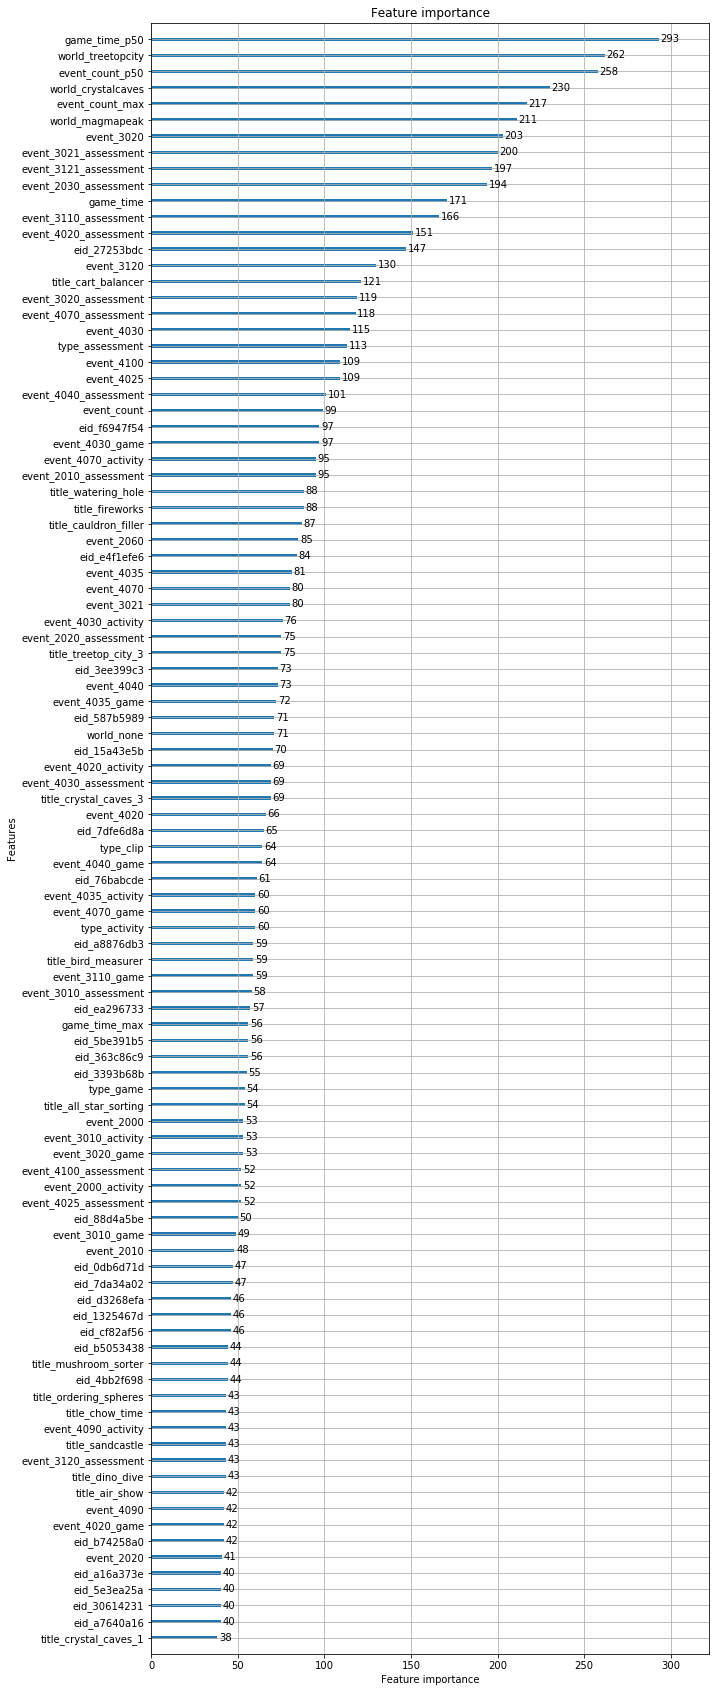

In [12]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30))

# Predict out of fold

In [13]:
oof = train[['installation_id']].copy()
oof[TARGET] = cv.predict(x_train)
assert oof[TARGET].min() > -0.5
assert oof[TARGET].max() < 3.5
oof[TARGET] = np.round(oof[TARGET]).astype(int)
oof.head()

,installation_id,accuracy_group
0,0006a69f,0
1,0006c192,0
2,00129856,0
3,001d0ed0,0
4,00225f67,0


In [14]:
score = cohen_kappa_score(oof[TARGET], y_train, weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.50556


# Predict on Test set

In [15]:
x_test = test[PREDICTORS]
sub = test[['installation_id']].copy()
sub[TARGET] = cv.predict(x_test)
assert sub[TARGET].min() > -0.5
assert sub[TARGET].max() < 3.5
sub[TARGET] = np.round(sub[TARGET]).astype(int)
sub.head()

,installation_id,accuracy_group
0,00abaee7,0
1,01242218,0
2,017c5718,1
3,01a44906,1
4,01bc6cb6,0


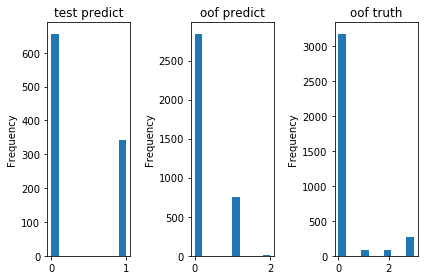

In [16]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [17]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']
